In [3]:
import os
os.chdir( "../")

In [2]:
import pandas as pd
import numpy as np

path = "Dataset/data_train.csv"
df = pd.read_csv(filepath_or_buffer=path,
                               sep=",",
                               header=1,
                               engine='python',
                               names=['UserID', 'ItemID', 'Interaction'])


df

,UserID,ItemID,Interaction
0,1,15,1.0
1,1,16,1.0
2,1,133,1.0
3,1,161,1.0
4,1,187,1.0
...,...,...,...
478724,13024,13605,1.0
478725,13024,13823,1.0
478726,13024,15122,1.0
478727,13024,18185,1.0


In [3]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [4]:
userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample



urm_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))

urm_train_validation, urm_test = split_train_in_two_percentage_global_sample(urm_all, train_percentage = 0.80)
urm_train, urm_validation = split_train_in_two_percentage_global_sample(urm_train_validation, train_percentage = 0.80)

In [6]:
num_users = len(userId_unique)
num_items = len(itemId_unique)

In [7]:
from Recommenders.Recommender_import_list import *
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10], ignore_users=[])

2023-12-28 14:05:54.100771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-28 14:05:54.100800: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


EvaluatorHoldout: Ignoring 2602 (20.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


In [8]:
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10], ignore_users=[])

EvaluatorHoldout: Ignoring 2128 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


In [9]:
import os

output_folder_path = "result_experiments_parallel/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
n_cases = 200  # using 10 as an example
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

In [10]:
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt


In [11]:
earlystopping_keywargs = {"validation_every_n": 5,
                          "stop_on_validation": True,
                          "evaluator_object": evaluator_validation,
                          "lower_validations_allowed": 5,
                          "validation_metric": metric_to_optimize,
                          }

In [12]:
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [urm_train],     # For a CBF model simply put [URM_train, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = earlystopping_keywargs,     # Additional hyperparameters for the fit function
)

In [13]:
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [urm_train_validation],     # For a CBF model simply put [URM_train_validation, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = earlystopping_keywargs,     # Additional hyperparameters for the fit function
)

In [14]:
#hyperparameterSearch = SearchBayesianSkopt(recommender_class,
#                                         evaluator_validation=evaluator_validation,
#                                         evaluator_test=evaluator_test)

In [15]:
similarity_type_list = ['cosine', 'jaccard', "asymmetric", "dice", "tversky"]

In [16]:
from HyperparameterTuning.run_hyperparameter_search import runHyperparameterSearch_Collaborative, runHyperparameterSearch_Content
from Recommenders.NonPersonalizedRecommender import TopPop, Random
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
import os, multiprocessing
from functools import partial


runHyperparameterSearch_Collaborative_partial = partial(runHyperparameterSearch_Collaborative,
       URM_train = urm_train,
       URM_train_last_test = urm_train_validation,
       metric_to_optimize = metric_to_optimize,
       cutoff_to_optimize = cutoff_to_optimize,
       evaluator_validation_earlystopping = evaluator_validation,
       evaluator_validation = evaluator_validation,
       evaluator_test = evaluator_test,
       output_folder_path = output_folder_path,
       parallelizeKNN = True,
       allow_weighting = True,
       resume_from_saved = True,
       save_model = "best",
       similarity_type_list = ['cosine', 'jaccard', "asymmetric", "dice", "tversky"],
       n_cases = n_cases,
       n_random_starts = n_random_starts)


In [17]:
from Recommenders.EASE_R.EASE_R_RecommenderV2 import EASE_R_RecommenderV2

collaborative_algorithm_list = [
    EASE_R_RecommenderV2
]

In [ ]:
from skopt.space import Real, Integer, Categorical


hyperparameters_range_dictionary = {
    "topK": Categorical([None]),
    "normalize_matrix": Categorical([False]),
    "l2_norm": Real(low = 0, high = 400, prior = 'uniform'),
}

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [urm_train],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

hyperparameterSearch = SearchBayesianSkopt(EASE_R_RecommenderV2,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

hyperparameterSearch.search(recommender_input_args,
                               hyperparameter_search_space= hyperparameters_range_dictionary,
                               n_cases = 100,
                               n_random_starts = n_random_starts,
                               resume_from_saved = True,
                               save_model = "best",
                               evaluate_on_test = "best",
                               max_total_time = None,
                               output_folder_path = output_folder_path,
                               output_file_name_root = EASE_R_RecommenderV2.RECOMMENDER_NAME,
                               metric_to_optimize = metric_to_optimize,
                               cutoff_to_optimize = cutoff_to_optimize,
                               recommender_input_args_last_test = recommender_input_args_last_test)

In [18]:
#pool = multiprocessing.Pool(processes=int(multiprocessing.cpu_count()), maxtasksperchild=1)
#pool.map(runHyperparameterSearch_Collaborative_partial, collaborative_algorithm_list)

SearchBayesianSkopt: Resuming 'EASE_R_RecommenderV2' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 47124.07928361357}
EASE_R_RecommenderV2: URM Detected 472 ( 3.7%) users with no interactions.
EASE_R_RecommenderV2: URM Detected 341 ( 1.5%) items with no interactions.
EASE_R_RecommenderV2: Fitting model... 


/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 102
EvaluatorHoldout: Processed 10036 (100.0%) in 5.01 sec. Users per second: 2002
SearchBayesianSkopt: New best config found. Config 0: {'topK': None, 'normalize_matrix': False, 'l2_norm': 47124.07928361357} - results: PRECISION: 0.0372758, PRECISION_RECALL_MIN_DEN: 0.0830239, RECALL: 0.0761191, MAP: 0.0143485, MAP_MIN_DEN: 0.0331156, MRR: 0.1130630, NDCG: 0.0645018, F1: 0.0500446, HIT_RATE: 0.2921483, ARHR_ALL_HITS: 0.1271638, NOVELTY: 0.0039970, AVERAGE_POPULARITY: 0.6655867, DIVERSITY_MEAN_INTER_LIST: 0.4821204, DIVERSITY_HERFINDAHL: 0.9482072, COVERAGE_ITEM: 0.0709657, COVERAGE_ITEM_HIT: 0.0092251, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2319987, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0026711, SHANNON_ENTROPY: 5.2654479, RATIO_DIVERSITY_HERFINDAHL: 0.9485507, RATIO_DIVERSITY_GINI: 0.0077393, RATIO_SHANNON_ENTROPY: 0.4059137, RATIO_AVERAGE_POPULARITY: 5.3907751, RATIO_NOVELTY: 0.282

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.79 min
Collected: 25
EvaluatorHoldout: Processed 10036 (100.0%) in 5.46 sec. Users per second: 1837
SearchBayesianSkopt: New best config found. Config 1: {'topK': None, 'normalize_matrix': False, 'l2_norm': 8.118686112989252} - results: PRECISION: 0.0512953, PRECISION_RECALL_MIN_DEN: 0.1052450, RECALL: 0.0953551, MAP: 0.0228472, MAP_MIN_DEN: 0.0484896, MRR: 0.1660782, NDCG: 0.0901720, F1: 0.0667065, HIT_RATE: 0.3667796, ARHR_ALL_HITS: 0.1941592, NOVELTY: 0.0046874, AVERAGE_POPULARITY: 0.3082374, DIVERSITY_MEAN_INTER_LIST: 0.9530801, DIVERSITY_HERFINDAHL: 0.9952985, COVERAGE_ITEM: 0.2239672, COVERAGE_ITEM_HIT: 0.0520655, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2912644, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0303177, SHANNON_ENTROPY: 9.2112404, RATIO_DIVERSITY_HERFINDAHL: 0.9956590, RATIO_DIVERSITY_GINI: 0.0878425, RATIO_SHANNON_ENTROPY: 0.7100952, RATIO_AVERAGE_POPULARITY: 2.4965018, RATIO_NOVELTY: 0.3312

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 508
EvaluatorHoldout: Processed 10036 (100.0%) in 5.28 sec. Users per second: 1902
SearchBayesianSkopt: New best config found. Config 2: {'topK': None, 'normalize_matrix': False, 'l2_norm': 21.15784998516597} - results: PRECISION: 0.0560383, PRECISION_RECALL_MIN_DEN: 0.1143343, RECALL: 0.1034155, MAP: 0.0251196, MAP_MIN_DEN: 0.0527638, MRR: 0.1776806, NDCG: 0.0977491, F1: 0.0726885, HIT_RATE: 0.3911917, ARHR_ALL_HITS: 0.2104861, NOVELTY: 0.0046525, AVERAGE_POPULARITY: 0.3169977, DIVERSITY_MEAN_INTER_LIST: 0.9494479, DIVERSITY_HERFINDAHL: 0.9949353, COVERAGE_ITEM: 0.1867519, COVERAGE_ITEM_HIT: 0.0516155, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3106504, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0253688, SHANNON_ENTROPY: 9.0532611, RATIO_DIVERSITY_HERFINDAHL: 0.9952957, RATIO_DIVERSITY_GINI: 0.0735037, RATIO_SHANNON_ENTROPY: 0.6979165, RATIO_AVERAGE_POPULARITY: 2.5674538, RATIO_NOVELTY: 0.328

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 508
EvaluatorHoldout: Processed 10036 (100.0%) in 5.17 sec. Users per second: 1941
SearchBayesianSkopt: Config 3 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2673013.6611677944} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732565, DIVERSITY_MEAN_INTER_LIST: 0.4599432, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491906, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969515, RATIO_AVERAGE_POPULARITY: 5.4528948, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 296
EvaluatorHoldout: Processed 10036 (100.0%) in 5.39 sec. Users per second: 1864
SearchBayesianSkopt: Config 4 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 14.0367181567749} - results: PRECISION: 0.0542945, PRECISION_RECALL_MIN_DEN: 0.1113898, RECALL: 0.1008401, MAP: 0.0242752, MAP_MIN_DEN: 0.0510989, MRR: 0.1735971, NDCG: 0.0950184, F1: 0.0705847, HIT_RATE: 0.3822240, ARHR_ALL_HITS: 0.2046237, NOVELTY: 0.0046659, AVERAGE_POPULARITY: 0.3133202, DIVERSITY_MEAN_INTER_LIST: 0.9510648, DIVERSITY_HERFINDAHL: 0.9950970, COVERAGE_ITEM: 0.1999370, COVERAGE_ITEM_HIT: 0.0522905, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3035290, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0271558, SHANNON_ENTROPY: 9.1163926, RATIO_DIVERSITY_HERFINDAHL: 0.9954575, RATIO_DIVERSITY_GINI: 0.0786814, RATIO_SHANNON_ENTROPY: 0.7027833, RATIO_AVERAGE_POPULARITY: 2.5376690, RATIO_NOVELTY: 0.32970

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.25 sec. Users per second: 1911
SearchBayesianSkopt: New best config found. Config 5: {'topK': None, 'normalize_matrix': False, 'l2_norm': 204.96734495473825} - results: PRECISION: 0.0586588, PRECISION_RECALL_MIN_DEN: 0.1215795, RECALL: 0.1100200, MAP: 0.0266569, MAP_MIN_DEN: 0.0557306, MRR: 0.1863338, NDCG: 0.1030492, F1: 0.0765199, HIT_RATE: 0.4058390, ARHR_ALL_HITS: 0.2220072, NOVELTY: 0.0045319, AVERAGE_POPULARITY: 0.3620886, DIVERSITY_MEAN_INTER_LIST: 0.9251032, DIVERSITY_HERFINDAHL: 0.9925011, COVERAGE_ITEM: 0.1394114, COVERAGE_ITEM_HIT: 0.0379354, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3222820, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0166280, SHANNON_ENTROPY: 8.4828401, RATIO_DIVERSITY_HERFINDAHL: 0.9928606, RATIO_DIVERSITY_GINI: 0.0481781, RATIO_SHANNON_ENTROPY: 0.6539427, RATIO_AVERAGE_POPULARITY: 2.9326580, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.79 min
Collected: 508
EvaluatorHoldout: Processed 10036 (100.0%) in 5.17 sec. Users per second: 1940
SearchBayesianSkopt: Config 6 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 268066.833043054} - results: PRECISION: 0.0361399, PRECISION_RECALL_MIN_DEN: 0.0801942, RECALL: 0.0734286, MAP: 0.0138141, MAP_MIN_DEN: 0.0318342, MRR: 0.1094217, NDCG: 0.0622568, F1: 0.0484391, HIT_RATE: 0.2842766, ARHR_ALL_HITS: 0.1227373, NOVELTY: 0.0039863, AVERAGE_POPULARITY: 0.6725238, DIVERSITY_MEAN_INTER_LIST: 0.4621989, DIVERSITY_HERFINDAHL: 0.9462153, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2257477, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025047, SHANNON_ENTROPY: 5.1605853, RATIO_DIVERSITY_HERFINDAHL: 0.9465580, RATIO_DIVERSITY_GINI: 0.0072570, RATIO_SHANNON_ENTROPY: 0.3978299, RATIO_AVERAGE_POPULARITY: 5.4469606, RATIO_NOVELTY: 0.28168

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 296
EvaluatorHoldout: Processed 10036 (100.0%) in 5.27 sec. Users per second: 1904
SearchBayesianSkopt: Config 7 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1105226.601917516} - results: PRECISION: 0.0359406, PRECISION_RECALL_MIN_DEN: 0.0798193, RECALL: 0.0730788, MAP: 0.0137020, MAP_MIN_DEN: 0.0316090, MRR: 0.1087814, NDCG: 0.0618897, F1: 0.0481840, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1218797, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732301, DIVERSITY_MEAN_INTER_LIST: 0.4600110, DIVERSITY_HERFINDAHL: 0.9459965, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024927, SHANNON_ENTROPY: 5.1495979, RATIO_DIVERSITY_HERFINDAHL: 0.9463392, RATIO_DIVERSITY_GINI: 0.0072224, RATIO_SHANNON_ENTROPY: 0.3969829, RATIO_AVERAGE_POPULARITY: 5.4526808, RATIO_NOVELTY: 0.2816

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.00 sec. Users per second: 2007
SearchBayesianSkopt: Config 8 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 8884.467906126549} - results: PRECISION: 0.0412714, PRECISION_RECALL_MIN_DEN: 0.0913587, RECALL: 0.0837052, MAP: 0.0166203, MAP_MIN_DEN: 0.0382432, MRR: 0.1279399, NDCG: 0.0727642, F1: 0.0552845, HIT_RATE: 0.3174572, ARHR_ALL_HITS: 0.1456030, NOVELTY: 0.0040607, AVERAGE_POPULARITY: 0.6255517, DIVERSITY_MEAN_INTER_LIST: 0.5797136, DIVERSITY_HERFINDAHL: 0.9579656, COVERAGE_ITEM: 0.0808658, COVERAGE_ITEM_HIT: 0.0122401, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2520969, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0038338, SHANNON_ENTROPY: 5.8021962, RATIO_DIVERSITY_HERFINDAHL: 0.9583126, RATIO_DIVERSITY_GINI: 0.0111080, RATIO_SHANNON_ENTROPY: 0.4472917, RATIO_AVERAGE_POPULARITY: 5.0665205, RATIO_NOVELTY: 0.2869

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.43 sec. Users per second: 1848
SearchBayesianSkopt: Config 9 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1726.2363784663692} - results: PRECISION: 0.0501993, PRECISION_RECALL_MIN_DEN: 0.1078906, RECALL: 0.0985305, MAP: 0.0221195, MAP_MIN_DEN: 0.0482157, MRR: 0.1629769, NDCG: 0.0897944, F1: 0.0665120, HIT_RATE: 0.3675767, ARHR_ALL_HITS: 0.1893689, NOVELTY: 0.0042560, AVERAGE_POPULARITY: 0.5066359, DIVERSITY_MEAN_INTER_LIST: 0.7865112, DIVERSITY_HERFINDAHL: 0.9786433, COVERAGE_ITEM: 0.1050761, COVERAGE_ITEM_HIT: 0.0204302, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2918975, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0079288, SHANNON_ENTROPY: 7.0843980, RATIO_DIVERSITY_HERFINDAHL: 0.9789978, RATIO_DIVERSITY_GINI: 0.0229729, RATIO_SHANNON_ENTROPY: 0.5461367, RATIO_AVERAGE_POPULARITY: 4.1033874, RATIO_NOVELTY: 0.300

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.63 sec. Users per second: 1781
SearchBayesianSkopt: Config 10 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 58.81643331862415} - results: PRECISION: 0.0587485, PRECISION_RECALL_MIN_DEN: 0.1196201, RECALL: 0.1079979, MAP: 0.0265623, MAP_MIN_DEN: 0.0555543, MRR: 0.1854203, NDCG: 0.1024525, F1: 0.0761002, HIT_RATE: 0.4043444, ARHR_ALL_HITS: 0.2211196, NOVELTY: 0.0046153, AVERAGE_POPULARITY: 0.3287668, DIVERSITY_MEAN_INTER_LIST: 0.9437475, DIVERSITY_HERFINDAHL: 0.9943653, COVERAGE_ITEM: 0.1636666, COVERAGE_ITEM_HIT: 0.0460805, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3210951, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0216004, SHANNON_ENTROPY: 8.8727425, RATIO_DIVERSITY_HERFINDAHL: 0.9947255, RATIO_DIVERSITY_GINI: 0.0625850, RATIO_SHANNON_ENTROPY: 0.6840003, RATIO_AVERAGE_POPULARITY: 2.6627752, RATIO_NOVELTY: 0.326

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.38 sec. Users per second: 1865
SearchBayesianSkopt: Config 11 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2.656185641623132} - results: PRECISION: 0.0444699, PRECISION_RECALL_MIN_DEN: 0.0909653, RECALL: 0.0824860, MAP: 0.0190919, MAP_MIN_DEN: 0.0413573, MRR: 0.1436057, NDCG: 0.0776570, F1: 0.0577861, HIT_RATE: 0.3296134, ARHR_ALL_HITS: 0.1651598, NOVELTY: 0.0047648, AVERAGE_POPULARITY: 0.2941023, DIVERSITY_MEAN_INTER_LIST: 0.9577090, DIVERSITY_HERFINDAHL: 0.9957614, COVERAGE_ITEM: 0.2979930, COVERAGE_ITEM_HIT: 0.0493655, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2617503, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0429507, SHANNON_ENTROPY: 9.5168119, RATIO_DIVERSITY_HERFINDAHL: 0.9961221, RATIO_DIVERSITY_GINI: 0.1244455, RATIO_SHANNON_ENTROPY: 0.7336517, RATIO_AVERAGE_POPULARITY: 2.3820176, RATIO_NOVELTY: 0.336

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.22 sec. Users per second: 1924
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 213.86105072770596} - results: PRECISION: 0.0586389, PRECISION_RECALL_MIN_DEN: 0.1215243, RECALL: 0.1099561, MAP: 0.0265990, MAP_MIN_DEN: 0.0556089, MRR: 0.1859791, NDCG: 0.1029084, F1: 0.0764875, HIT_RATE: 0.4059386, ARHR_ALL_HITS: 0.2215850, NOVELTY: 0.0045279, AVERAGE_POPULARITY: 0.3638020, DIVERSITY_MEAN_INTER_LIST: 0.9240550, DIVERSITY_HERFINDAHL: 0.9923963, COVERAGE_ITEM: 0.1385564, COVERAGE_ITEM_HIT: 0.0376204, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3223611, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0164324, SHANNON_ENTROPY: 8.4639895, RATIO_DIVERSITY_HERFINDAHL: 0.9927558, RATIO_DIVERSITY_GINI: 0.0476111, RATIO_SHANNON_ENTROPY: 0.6524895, RATIO_AVERAGE_POPULARITY: 2.9465357, RATIO_NOVELTY: 0.31

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.10 sec. Users per second: 1967
SearchBayesianSkopt: Config 13 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1441803.880587985} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797894, RECALL: 0.0730522, MAP: 0.0136877, MAP_MIN_DEN: 0.0315839, MRR: 0.1087284, NDCG: 0.0618579, F1: 0.0481603, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217869, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732509, DIVERSITY_MEAN_INTER_LIST: 0.4599575, DIVERSITY_HERFINDAHL: 0.9459912, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024924, SHANNON_ENTROPY: 5.1492893, RATIO_DIVERSITY_HERFINDAHL: 0.9463338, RATIO_DIVERSITY_GINI: 0.0072215, RATIO_SHANNON_ENTROPY: 0.3969591, RATIO_AVERAGE_POPULARITY: 5.4528498, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.91 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.48 sec. Users per second: 1830
SearchBayesianSkopt: Config 14 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 223.70440727509327} - results: PRECISION: 0.0585393, PRECISION_RECALL_MIN_DEN: 0.1214336, RECALL: 0.1098906, MAP: 0.0265655, MAP_MIN_DEN: 0.0555775, MRR: 0.1858214, NDCG: 0.1028230, F1: 0.0763869, HIT_RATE: 0.4050418, ARHR_ALL_HITS: 0.2213616, NOVELTY: 0.0045242, AVERAGE_POPULARITY: 0.3654886, DIVERSITY_MEAN_INTER_LIST: 0.9229832, DIVERSITY_HERFINDAHL: 0.9922891, COVERAGE_ITEM: 0.1381514, COVERAGE_ITEM_HIT: 0.0372604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3216490, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0162865, SHANNON_ENTROPY: 8.4471681, RATIO_DIVERSITY_HERFINDAHL: 0.9926486, RATIO_DIVERSITY_GINI: 0.0471885, RATIO_SHANNON_ENTROPY: 0.6511928, RATIO_AVERAGE_POPULARITY: 2.9601954, RATIO_NOVELTY: 0.31

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.96 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.21 sec. Users per second: 1926
SearchBayesianSkopt: Config 15 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 262.89979216897746} - results: PRECISION: 0.0581706, PRECISION_RECALL_MIN_DEN: 0.1211430, RECALL: 0.1096940, MAP: 0.0263747, MAP_MIN_DEN: 0.0551950, MRR: 0.1850714, NDCG: 0.1022952, F1: 0.0760251, HIT_RATE: 0.4029494, ARHR_ALL_HITS: 0.2201689, NOVELTY: 0.0045086, AVERAGE_POPULARITY: 0.3724911, DIVERSITY_MEAN_INTER_LIST: 0.9184365, DIVERSITY_HERFINDAHL: 0.9918345, COVERAGE_ITEM: 0.1356314, COVERAGE_ITEM_HIT: 0.0356404, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3199873, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0156184, SHANNON_ENTROPY: 8.3749185, RATIO_DIVERSITY_HERFINDAHL: 0.9921938, RATIO_DIVERSITY_GINI: 0.0452527, RATIO_SHANNON_ENTROPY: 0.6456231, RATIO_AVERAGE_POPULARITY: 3.0169112, RATIO_NOVELTY: 0.31

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.96 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.23 sec. Users per second: 1917
SearchBayesianSkopt: Config 16 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 22.451608915050965} - results: PRECISION: 0.0563372, PRECISION_RECALL_MIN_DEN: 0.1147443, RECALL: 0.1037593, MAP: 0.0252551, MAP_MIN_DEN: 0.0530783, MRR: 0.1785171, NDCG: 0.0982328, F1: 0.0730248, HIT_RATE: 0.3928856, ARHR_ALL_HITS: 0.2115171, NOVELTY: 0.0046513, AVERAGE_POPULARITY: 0.3172907, DIVERSITY_MEAN_INTER_LIST: 0.9493059, DIVERSITY_HERFINDAHL: 0.9949211, COVERAGE_ITEM: 0.1855819, COVERAGE_ITEM_HIT: 0.0517505, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3119956, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0251892, SHANNON_ENTROPY: 9.0467260, RATIO_DIVERSITY_HERFINDAHL: 0.9952815, RATIO_DIVERSITY_GINI: 0.0729831, RATIO_SHANNON_ENTROPY: 0.6974127, RATIO_AVERAGE_POPULARITY: 2.5698271, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.92 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.43 sec. Users per second: 1849
SearchBayesianSkopt: Config 17 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1.0747548186358773} - results: PRECISION: 0.0375648, PRECISION_RECALL_MIN_DEN: 0.0776392, RECALL: 0.0704831, MAP: 0.0159524, MAP_MIN_DEN: 0.0350263, MRR: 0.1237550, NDCG: 0.0661122, F1: 0.0490094, HIT_RATE: 0.2883619, ARHR_ALL_HITS: 0.1402677, NOVELTY: 0.0048606, AVERAGE_POPULARITY: 0.2769241, DIVERSITY_MEAN_INTER_LIST: 0.9627631, DIVERSITY_HERFINDAHL: 0.9962667, COVERAGE_ITEM: 0.3497435, COVERAGE_ITEM_HIT: 0.0437404, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2289919, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0575435, SHANNON_ENTROPY: 9.8471349, RATIO_DIVERSITY_HERFINDAHL: 0.9966276, RATIO_DIVERSITY_GINI: 0.1667266, RATIO_SHANNON_ENTROPY: 0.7591163, RATIO_AVERAGE_POPULARITY: 2.2428862, RATIO_NOVELTY: 0.34

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.94 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.71 sec. Users per second: 1757
SearchBayesianSkopt: Config 18 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1.8089234545850759} - results: PRECISION: 0.0415405, PRECISION_RECALL_MIN_DEN: 0.0854697, RECALL: 0.0776235, MAP: 0.0177416, MAP_MIN_DEN: 0.0386204, MRR: 0.1353485, NDCG: 0.0727966, F1: 0.0541190, HIT_RATE: 0.3134715, ARHR_ALL_HITS: 0.1546433, NOVELTY: 0.0048027, AVERAGE_POPULARITY: 0.2872834, DIVERSITY_MEAN_INTER_LIST: 0.9597666, DIVERSITY_HERFINDAHL: 0.9959671, COVERAGE_ITEM: 0.3231482, COVERAGE_ITEM_HIT: 0.0469805, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2489318, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0490524, SHANNON_ENTROPY: 9.6539427, RATIO_DIVERSITY_HERFINDAHL: 0.9963279, RATIO_DIVERSITY_GINI: 0.1421244, RATIO_SHANNON_ENTROPY: 0.7442231, RATIO_AVERAGE_POPULARITY: 2.3267895, RATIO_NOVELTY: 0.33

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.89 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.53 sec. Users per second: 1816
SearchBayesianSkopt: Config 19 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4778.472673265888} - results: PRECISION: 0.0439916, PRECISION_RECALL_MIN_DEN: 0.0962390, RECALL: 0.0880611, MAP: 0.0184806, MAP_MIN_DEN: 0.0418095, MRR: 0.1402590, NDCG: 0.0785162, F1: 0.0586728, HIT_RATE: 0.3341969, ARHR_ALL_HITS: 0.1606805, NOVELTY: 0.0041176, AVERAGE_POPULARITY: 0.5900856, DIVERSITY_MEAN_INTER_LIST: 0.6523555, DIVERSITY_HERFINDAHL: 0.9652290, COVERAGE_ITEM: 0.0887409, COVERAGE_ITEM_HIT: 0.0146701, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2653901, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0049460, SHANNON_ENTROPY: 6.2164941, RATIO_DIVERSITY_HERFINDAHL: 0.9655787, RATIO_DIVERSITY_GINI: 0.0143306, RATIO_SHANNON_ENTROPY: 0.4792300, RATIO_AVERAGE_POPULARITY: 4.7792702, RATIO_NOVELTY: 0.290

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.96 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.22 sec. Users per second: 1924
SearchBayesianSkopt: Config 20 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 13769.140051606639} - results: PRECISION: 0.0398964, PRECISION_RECALL_MIN_DEN: 0.0883305, RECALL: 0.0809283, MAP: 0.0158092, MAP_MIN_DEN: 0.0363884, MRR: 0.1228559, NDCG: 0.0698275, F1: 0.0534451, HIT_RATE: 0.3093862, ARHR_ALL_HITS: 0.1391429, NOVELTY: 0.0040339, AVERAGE_POPULARITY: 0.6424105, DIVERSITY_MEAN_INTER_LIST: 0.5410545, DIVERSITY_HERFINDAHL: 0.9541001, COVERAGE_ITEM: 0.0771758, COVERAGE_ITEM_HIT: 0.0111601, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2456876, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0033370, SHANNON_ENTROPY: 5.5877724, RATIO_DIVERSITY_HERFINDAHL: 0.9544457, RATIO_DIVERSITY_GINI: 0.0096685, RATIO_SHANNON_ENTROPY: 0.4307618, RATIO_AVERAGE_POPULARITY: 5.2030644, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.90 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.04 sec. Users per second: 1990
SearchBayesianSkopt: Config 21 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 280729.2852922625} - results: PRECISION: 0.0361200, PRECISION_RECALL_MIN_DEN: 0.0801675, RECALL: 0.0734019, MAP: 0.0138079, MAP_MIN_DEN: 0.0318184, MRR: 0.1093985, NDCG: 0.0622309, F1: 0.0484154, HIT_RATE: 0.2841770, ARHR_ALL_HITS: 0.1226949, NOVELTY: 0.0039862, AVERAGE_POPULARITY: 0.6725858, DIVERSITY_MEAN_INTER_LIST: 0.4620245, DIVERSITY_HERFINDAHL: 0.9461978, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2256686, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025032, SHANNON_ENTROPY: 5.1595760, RATIO_DIVERSITY_HERFINDAHL: 0.9465406, RATIO_DIVERSITY_GINI: 0.0072527, RATIO_SHANNON_ENTROPY: 0.3977521, RATIO_AVERAGE_POPULARITY: 5.4474623, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.91 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.27 sec. Users per second: 1904
SearchBayesianSkopt: Config 22 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1500.615834724822} - results: PRECISION: 0.0510961, PRECISION_RECALL_MIN_DEN: 0.1094830, RECALL: 0.0999355, MAP: 0.0225591, MAP_MIN_DEN: 0.0488674, MRR: 0.1653211, NDCG: 0.0911045, F1: 0.0676191, HIT_RATE: 0.3722599, ARHR_ALL_HITS: 0.1925748, NOVELTY: 0.0042774, AVERAGE_POPULARITY: 0.4941951, DIVERSITY_MEAN_INTER_LIST: 0.8027519, DIVERSITY_HERFINDAHL: 0.9802672, COVERAGE_ITEM: 0.1074161, COVERAGE_ITEM_HIT: 0.0214202, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2956164, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0084384, SHANNON_ENTROPY: 7.2059952, RATIO_DIVERSITY_HERFINDAHL: 0.9806223, RATIO_DIVERSITY_GINI: 0.0244494, RATIO_SHANNON_ENTROPY: 0.5555107, RATIO_AVERAGE_POPULARITY: 4.0026261, RATIO_NOVELTY: 0.302

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.92 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.58 sec. Users per second: 1800
SearchBayesianSkopt: Config 23 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 45.97303243554321} - results: PRECISION: 0.0583001, PRECISION_RECALL_MIN_DEN: 0.1184492, RECALL: 0.1068838, MAP: 0.0262815, MAP_MIN_DEN: 0.0550693, MRR: 0.1838899, NDCG: 0.1015711, F1: 0.0754473, HIT_RATE: 0.4030490, ARHR_ALL_HITS: 0.2189946, NOVELTY: 0.0046262, AVERAGE_POPULARITY: 0.3249220, DIVERSITY_MEAN_INTER_LIST: 0.9456802, DIVERSITY_HERFINDAHL: 0.9945586, COVERAGE_ITEM: 0.1684817, COVERAGE_ITEM_HIT: 0.0475655, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3200665, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0224936, SHANNON_ENTROPY: 8.9238784, RATIO_DIVERSITY_HERFINDAHL: 0.9949189, RATIO_DIVERSITY_GINI: 0.0651731, RATIO_SHANNON_ENTROPY: 0.6879424, RATIO_AVERAGE_POPULARITY: 2.6316348, RATIO_NOVELTY: 0.326

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.99 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.18 sec. Users per second: 1939
SearchBayesianSkopt: Config 24 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 3383489.781415124} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797811, RECALL: 0.0730439, MAP: 0.0136867, MAP_MIN_DEN: 0.0315803, MRR: 0.1087449, NDCG: 0.0618558, F1: 0.0481585, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1217909, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732570, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491904, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528989, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.05 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.31 sec. Users per second: 1892
SearchBayesianSkopt: Config 25 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 75916.13590388093} - results: PRECISION: 0.0367477, PRECISION_RECALL_MIN_DEN: 0.0818361, RECALL: 0.0749998, MAP: 0.0140996, MAP_MIN_DEN: 0.0325200, MRR: 0.1114081, NDCG: 0.0634992, F1: 0.0493268, HIT_RATE: 0.2885612, ARHR_ALL_HITS: 0.1251380, NOVELTY: 0.0039916, AVERAGE_POPULARITY: 0.6690422, DIVERSITY_MEAN_INTER_LIST: 0.4723936, DIVERSITY_HERFINDAHL: 0.9472347, COVERAGE_ITEM: 0.0700657, COVERAGE_ITEM_HIT: 0.0087301, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2291502, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025808, SHANNON_ENTROPY: 5.2145805, RATIO_DIVERSITY_HERFINDAHL: 0.9475778, RATIO_DIVERSITY_GINI: 0.0074777, RATIO_SHANNON_ENTROPY: 0.4019924, RATIO_AVERAGE_POPULARITY: 5.4187621, RATIO_NOVELTY: 0.282

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.97 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.28 sec. Users per second: 1899
SearchBayesianSkopt: Config 26 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2468.269522989246} - results: PRECISION: 0.0481168, PRECISION_RECALL_MIN_DEN: 0.1045170, RECALL: 0.0955459, MAP: 0.0208343, MAP_MIN_DEN: 0.0457586, MRR: 0.1553153, NDCG: 0.0858948, F1: 0.0640022, HIT_RATE: 0.3579115, ARHR_ALL_HITS: 0.1794208, NOVELTY: 0.0042037, AVERAGE_POPULARITY: 0.5377150, DIVERSITY_MEAN_INTER_LIST: 0.7419066, DIVERSITY_HERFINDAHL: 0.9741833, COVERAGE_ITEM: 0.0989110, COVERAGE_ITEM_HIT: 0.0184502, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2842222, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0067295, SHANNON_ENTROPY: 6.7741245, RATIO_DIVERSITY_HERFINDAHL: 0.9745362, RATIO_DIVERSITY_GINI: 0.0194981, RATIO_SHANNON_ENTROPY: 0.5222177, RATIO_AVERAGE_POPULARITY: 4.3551057, RATIO_NOVELTY: 0.297

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.50 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.15 sec. Users per second: 1950
SearchBayesianSkopt: Config 27 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 111379.92238667936} - results: PRECISION: 0.0364189, PRECISION_RECALL_MIN_DEN: 0.0810663, RECALL: 0.0742716, MAP: 0.0139696, MAP_MIN_DEN: 0.0321889, MRR: 0.1105691, NDCG: 0.0629026, F1: 0.0488730, HIT_RATE: 0.2861698, ARHR_ALL_HITS: 0.1240678, NOVELTY: 0.0039889, AVERAGE_POPULARITY: 0.6707612, DIVERSITY_MEAN_INTER_LIST: 0.4675127, DIVERSITY_HERFINDAHL: 0.9467466, COVERAGE_ITEM: 0.0697957, COVERAGE_ITEM_HIT: 0.0085051, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2272511, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025411, SHANNON_ENTROPY: 5.1884875, RATIO_DIVERSITY_HERFINDAHL: 0.9470896, RATIO_DIVERSITY_GINI: 0.0073627, RATIO_SHANNON_ENTROPY: 0.3999809, RATIO_AVERAGE_POPULARITY: 5.4326848, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.14 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.63 sec. Users per second: 1782
SearchBayesianSkopt: Config 28 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 5104552.009650606} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732568, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528969, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.03 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.37 sec. Users per second: 1869
SearchBayesianSkopt: New best config found. Config 29: {'topK': None, 'normalize_matrix': False, 'l2_norm': 123.26256669770004} - results: PRECISION: 0.0591969, PRECISION_RECALL_MIN_DEN: 0.1222018, RECALL: 0.1106188, MAP: 0.0269682, MAP_MIN_DEN: 0.0563150, MRR: 0.1883963, NDCG: 0.1039728, F1: 0.0771223, HIT_RATE: 0.4085293, ARHR_ALL_HITS: 0.2246313, NOVELTY: 0.0045723, AVERAGE_POPULARITY: 0.3451673, DIVERSITY_MEAN_INTER_LIST: 0.9350379, DIVERSITY_HERFINDAHL: 0.9934945, COVERAGE_ITEM: 0.1487715, COVERAGE_ITEM_HIT: 0.0419854, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3244184, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0187212, SHANNON_ENTROPY: 8.6701505, RATIO_DIVERSITY_HERFINDAHL: 0.9938544, RATIO_DIVERSITY_GINI: 0.0542429, RATIO_SHANNON_ENTROPY: 0.6683825, RATIO_AVERAGE_POPULARITY: 2.7956074, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.20 min
Collected: 305
EvaluatorHoldout: Processed 10036 (100.0%) in 5.47 sec. Users per second: 1835
SearchBayesianSkopt: Config 30 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 5.898673984222338} - results: PRECISION: 0.0494520, PRECISION_RECALL_MIN_DEN: 0.1018234, RECALL: 0.0923289, MAP: 0.0218255, MAP_MIN_DEN: 0.0466334, MRR: 0.1600840, NDCG: 0.0869531, F1: 0.0644071, HIT_RATE: 0.3576126, ARHR_ALL_HITS: 0.1863887, NOVELTY: 0.0047032, AVERAGE_POPULARITY: 0.3052833, DIVERSITY_MEAN_INTER_LIST: 0.9541111, DIVERSITY_HERFINDAHL: 0.9954016, COVERAGE_ITEM: 0.2428224, COVERAGE_ITEM_HIT: 0.0513005, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2839848, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0329311, SHANNON_ENTROPY: 9.2778630, RATIO_DIVERSITY_HERFINDAHL: 0.9957622, RATIO_DIVERSITY_GINI: 0.0954145, RATIO_SHANNON_ENTROPY: 0.7152311, RATIO_AVERAGE_POPULARITY: 2.4725759, RATIO_NOVELTY: 0.332

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.00 min
Collected: 296
EvaluatorHoldout: Processed 10036 (100.0%) in 5.05 sec. Users per second: 1989
SearchBayesianSkopt: Config 31 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 8406236.094232365} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797811, RECALL: 0.0730439, MAP: 0.0136867, MAP_MIN_DEN: 0.0315803, MRR: 0.1087449, NDCG: 0.0618558, F1: 0.0481585, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1217909, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732566, DIVERSITY_MEAN_INTER_LIST: 0.4599443, DIVERSITY_HERFINDAHL: 0.9459898, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491925, RATIO_DIVERSITY_HERFINDAHL: 0.9463325, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969516, RATIO_AVERAGE_POPULARITY: 5.4528955, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.36 sec. Users per second: 1873
SearchBayesianSkopt: Config 32 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 3.606355229886082} - results: PRECISION: 0.0464727, PRECISION_RECALL_MIN_DEN: 0.0954496, RECALL: 0.0865834, MAP: 0.0201151, MAP_MIN_DEN: 0.0433057, MRR: 0.1504341, NDCG: 0.0813354, F1: 0.0604822, HIT_RATE: 0.3426664, ARHR_ALL_HITS: 0.1735263, NOVELTY: 0.0047369, AVERAGE_POPULARITY: 0.2992201, DIVERSITY_MEAN_INTER_LIST: 0.9560890, DIVERSITY_HERFINDAHL: 0.9955994, COVERAGE_ITEM: 0.2763928, COVERAGE_ITEM_HIT: 0.0503105, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2721158, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0384802, SHANNON_ENTROPY: 9.4117676, RATIO_DIVERSITY_HERFINDAHL: 0.9959600, RATIO_DIVERSITY_GINI: 0.1114927, RATIO_SHANNON_ENTROPY: 0.7255538, RATIO_AVERAGE_POPULARITY: 2.4234686, RATIO_NOVELTY: 0.334

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.69 sec. Users per second: 1764
SearchBayesianSkopt: Config 33 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 151.3457610194935} - results: PRECISION: 0.0591770, PRECISION_RECALL_MIN_DEN: 0.1218226, RECALL: 0.1101328, MAP: 0.0268752, MAP_MIN_DEN: 0.0560260, MRR: 0.1875139, NDCG: 0.1036116, F1: 0.0769870, HIT_RATE: 0.4081307, ARHR_ALL_HITS: 0.2236535, NOVELTY: 0.0045566, AVERAGE_POPULARITY: 0.3514807, DIVERSITY_MEAN_INTER_LIST: 0.9314640, DIVERSITY_HERFINDAHL: 0.9931371, COVERAGE_ITEM: 0.1444964, COVERAGE_ITEM_HIT: 0.0402754, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3241019, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0178336, SHANNON_ENTROPY: 8.5977945, RATIO_DIVERSITY_HERFINDAHL: 0.9934969, RATIO_DIVERSITY_GINI: 0.0516710, RATIO_SHANNON_ENTROPY: 0.6628046, RATIO_AVERAGE_POPULARITY: 2.8467414, RATIO_NOVELTY: 0.321

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.96 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.16 sec. Users per second: 1943
SearchBayesianSkopt: Config 34 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 8341651.717583727} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732577, DIVERSITY_MEAN_INTER_LIST: 0.4599430, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024919, SHANNON_ENTROPY: 5.1491567, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072201, RATIO_SHANNON_ENTROPY: 0.3969488, RATIO_AVERAGE_POPULARITY: 5.4529043, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.18 sec. Users per second: 1938
SearchBayesianSkopt: Config 35 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1071121.7359665674} - results: PRECISION: 0.0359406, PRECISION_RECALL_MIN_DEN: 0.0798193, RECALL: 0.0730788, MAP: 0.0137018, MAP_MIN_DEN: 0.0316087, MRR: 0.1087796, NDCG: 0.0618891, F1: 0.0481840, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1218779, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732194, DIVERSITY_MEAN_INTER_LIST: 0.4600465, DIVERSITY_HERFINDAHL: 0.9460001, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024928, SHANNON_ENTROPY: 5.1497342, RATIO_DIVERSITY_HERFINDAHL: 0.9463427, RATIO_DIVERSITY_GINI: 0.0072227, RATIO_SHANNON_ENTROPY: 0.3969934, RATIO_AVERAGE_POPULARITY: 5.4525943, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.90 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 4.96 sec. Users per second: 2025
SearchBayesianSkopt: Config 36 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4815068.602279101} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732570, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528988, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.17 sec. Users per second: 1943
SearchBayesianSkopt: Config 37 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2851.479892974225} - results: PRECISION: 0.0471204, PRECISION_RECALL_MIN_DEN: 0.1029895, RECALL: 0.0942581, MAP: 0.0202822, MAP_MIN_DEN: 0.0449326, MRR: 0.1523391, NDCG: 0.0843764, F1: 0.0628310, HIT_RATE: 0.3540255, ARHR_ALL_HITS: 0.1753896, NOVELTY: 0.0041831, AVERAGE_POPULARITY: 0.5500823, DIVERSITY_MEAN_INTER_LIST: 0.7223643, DIVERSITY_HERFINDAHL: 0.9722292, COVERAGE_ITEM: 0.0968410, COVERAGE_ITEM_HIT: 0.0176402, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2811363, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0062935, SHANNON_ENTROPY: 6.6477735, RATIO_DIVERSITY_HERFINDAHL: 0.9725814, RATIO_DIVERSITY_GINI: 0.0182348, RATIO_SHANNON_ENTROPY: 0.5124773, RATIO_AVERAGE_POPULARITY: 4.4552724, RATIO_NOVELTY: 0.295

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.27 sec. Users per second: 1903
SearchBayesianSkopt: Config 38 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 311.9133994639767} - results: PRECISION: 0.0578816, PRECISION_RECALL_MIN_DEN: 0.1204845, RECALL: 0.1091431, MAP: 0.0262006, MAP_MIN_DEN: 0.0548440, MRR: 0.1837790, NDCG: 0.1016758, F1: 0.0756460, HIT_RATE: 0.4006576, ARHR_ALL_HITS: 0.2187052, NOVELTY: 0.0044909, AVERAGE_POPULARITY: 0.3807795, DIVERSITY_MEAN_INTER_LIST: 0.9128057, DIVERSITY_HERFINDAHL: 0.9912715, COVERAGE_ITEM: 0.1325713, COVERAGE_ITEM_HIT: 0.0337953, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3181674, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0148674, SHANNON_ENTROPY: 8.2908673, RATIO_DIVERSITY_HERFINDAHL: 0.9916305, RATIO_DIVERSITY_GINI: 0.0430767, RATIO_SHANNON_ENTROPY: 0.6391435, RATIO_AVERAGE_POPULARITY: 3.0840411, RATIO_NOVELTY: 0.317

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.30 sec. Users per second: 1892
SearchBayesianSkopt: Config 39 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 810.5233626779565} - results: PRECISION: 0.0548525, PRECISION_RECALL_MIN_DEN: 0.1157377, RECALL: 0.1052568, MAP: 0.0242241, MAP_MIN_DEN: 0.0513446, MRR: 0.1736400, NDCG: 0.0961814, F1: 0.0721207, HIT_RATE: 0.3901953, ARHR_ALL_HITS: 0.2043765, NOVELTY: 0.0043708, AVERAGE_POPULARITY: 0.4419961, DIVERSITY_MEAN_INTER_LIST: 0.8614083, DIVERSITY_HERFINDAHL: 0.9861322, COVERAGE_ITEM: 0.1165512, COVERAGE_ITEM_HIT: 0.0265953, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3098592, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0108639, SHANNON_ENTROPY: 7.7039942, RATIO_DIVERSITY_HERFINDAHL: 0.9864895, RATIO_DIVERSITY_GINI: 0.0314771, RATIO_SHANNON_ENTROPY: 0.5939014, RATIO_AVERAGE_POPULARITY: 3.5798514, RATIO_NOVELTY: 0.308

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.07 sec. Users per second: 1981
SearchBayesianSkopt: Config 40 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 21513.45918855814} - results: PRECISION: 0.0387206, PRECISION_RECALL_MIN_DEN: 0.0860658, RECALL: 0.0788712, MAP: 0.0151193, MAP_MIN_DEN: 0.0348844, MRR: 0.1183041, NDCG: 0.0674148, F1: 0.0519414, HIT_RATE: 0.3017138, ARHR_ALL_HITS: 0.1335365, NOVELTY: 0.0040154, AVERAGE_POPULARITY: 0.6539698, DIVERSITY_MEAN_INTER_LIST: 0.5126658, DIVERSITY_HERFINDAHL: 0.9512615, COVERAGE_ITEM: 0.0739807, COVERAGE_ITEM_HIT: 0.0106201, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2395949, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0029965, SHANNON_ENTROPY: 5.4311234, RATIO_DIVERSITY_HERFINDAHL: 0.9516061, RATIO_DIVERSITY_GINI: 0.0086822, RATIO_SHANNON_ENTROPY: 0.4186857, RATIO_AVERAGE_POPULARITY: 5.2966864, RATIO_NOVELTY: 0.283

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.18 sec. Users per second: 1939
SearchBayesianSkopt: Config 41 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 299.85600637046844} - results: PRECISION: 0.0578916, PRECISION_RECALL_MIN_DEN: 0.1206202, RECALL: 0.1092867, MAP: 0.0262323, MAP_MIN_DEN: 0.0548841, MRR: 0.1841029, NDCG: 0.1017714, F1: 0.0756890, HIT_RATE: 0.4011558, ARHR_ALL_HITS: 0.2190138, NOVELTY: 0.0044952, AVERAGE_POPULARITY: 0.3787017, DIVERSITY_MEAN_INTER_LIST: 0.9142440, DIVERSITY_HERFINDAHL: 0.9914153, COVERAGE_ITEM: 0.1330663, COVERAGE_ITEM_HIT: 0.0342903, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3185631, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0150352, SHANNON_ENTROPY: 8.3112537, RATIO_DIVERSITY_HERFINDAHL: 0.9917744, RATIO_DIVERSITY_GINI: 0.0435630, RATIO_SHANNON_ENTROPY: 0.6407151, RATIO_AVERAGE_POPULARITY: 3.0672120, RATIO_NOVELTY: 0.31

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.27 sec. Users per second: 1905
SearchBayesianSkopt: Config 42 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4026.9218870981986} - results: PRECISION: 0.0448585, PRECISION_RECALL_MIN_DEN: 0.0981945, RECALL: 0.0898633, MAP: 0.0190328, MAP_MIN_DEN: 0.0428306, MRR: 0.1441577, NDCG: 0.0803337, F1: 0.0598438, HIT_RATE: 0.3403747, ARHR_ALL_HITS: 0.1653180, NOVELTY: 0.0041378, AVERAGE_POPULARITY: 0.5778032, DIVERSITY_MEAN_INTER_LIST: 0.6749768, DIVERSITY_HERFINDAHL: 0.9674910, COVERAGE_ITEM: 0.0916659, COVERAGE_ITEM_HIT: 0.0155702, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2702959, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0053594, SHANNON_ENTROPY: 6.3531480, RATIO_DIVERSITY_HERFINDAHL: 0.9678414, RATIO_DIVERSITY_GINI: 0.0155284, RATIO_SHANNON_ENTROPY: 0.4897646, RATIO_AVERAGE_POPULARITY: 4.6797920, RATIO_NOVELTY: 0.29

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.26 sec. Users per second: 1907
SearchBayesianSkopt: Config 43 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 83.01803208625044} - results: PRECISION: 0.0591371, PRECISION_RECALL_MIN_DEN: 0.1211641, RECALL: 0.1094895, MAP: 0.0267981, MAP_MIN_DEN: 0.0560020, MRR: 0.1870464, NDCG: 0.1033714, F1: 0.0767956, HIT_RATE: 0.4081307, ARHR_ALL_HITS: 0.2230895, NOVELTY: 0.0045979, AVERAGE_POPULARITY: 0.3351452, DIVERSITY_MEAN_INTER_LIST: 0.9404364, DIVERSITY_HERFINDAHL: 0.9940343, COVERAGE_ITEM: 0.1566016, COVERAGE_ITEM_HIT: 0.0445054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3241019, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0203088, SHANNON_ENTROPY: 8.7891366, RATIO_DIVERSITY_HERFINDAHL: 0.9943943, RATIO_DIVERSITY_GINI: 0.0588426, RATIO_SHANNON_ENTROPY: 0.6775552, RATIO_AVERAGE_POPULARITY: 2.7144362, RATIO_NOVELTY: 0.324

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.11 sec. Users per second: 1965
SearchBayesianSkopt: Config 44 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 240761.86836420774} - results: PRECISION: 0.0361698, PRECISION_RECALL_MIN_DEN: 0.0802283, RECALL: 0.0734528, MAP: 0.0138298, MAP_MIN_DEN: 0.0318709, MRR: 0.1094915, NDCG: 0.0623061, F1: 0.0484713, HIT_RATE: 0.2843762, ARHR_ALL_HITS: 0.1228359, NOVELTY: 0.0039865, AVERAGE_POPULARITY: 0.6724046, DIVERSITY_MEAN_INTER_LIST: 0.4625599, DIVERSITY_HERFINDAHL: 0.9462514, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2258269, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025064, SHANNON_ENTROPY: 5.1623994, RATIO_DIVERSITY_HERFINDAHL: 0.9465941, RATIO_DIVERSITY_GINI: 0.0072622, RATIO_SHANNON_ENTROPY: 0.3979697, RATIO_AVERAGE_POPULARITY: 5.4459951, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.36 sec. Users per second: 1872
SearchBayesianSkopt: Config 45 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 48.41813932680596} - results: PRECISION: 0.0583499, PRECISION_RECALL_MIN_DEN: 0.1186652, RECALL: 0.1070892, MAP: 0.0263344, MAP_MIN_DEN: 0.0552859, MRR: 0.1844471, NDCG: 0.1018370, F1: 0.0755401, HIT_RATE: 0.4033479, ARHR_ALL_HITS: 0.2195394, NOVELTY: 0.0046241, AVERAGE_POPULARITY: 0.3256732, DIVERSITY_MEAN_INTER_LIST: 0.9453014, DIVERSITY_HERFINDAHL: 0.9945207, COVERAGE_ITEM: 0.1674917, COVERAGE_ITEM_HIT: 0.0470705, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3203038, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0223152, SHANNON_ENTROPY: 8.9141495, RATIO_DIVERSITY_HERFINDAHL: 0.9948810, RATIO_DIVERSITY_GINI: 0.0646562, RATIO_SHANNON_ENTROPY: 0.6871924, RATIO_AVERAGE_POPULARITY: 2.6377191, RATIO_NOVELTY: 0.326

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.25 sec. Users per second: 1913
SearchBayesianSkopt: Config 46 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1131595.9158598625} - results: PRECISION: 0.0359406, PRECISION_RECALL_MIN_DEN: 0.0798193, RECALL: 0.0730788, MAP: 0.0137020, MAP_MIN_DEN: 0.0316090, MRR: 0.1087814, NDCG: 0.0618897, F1: 0.0481840, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1218797, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732301, DIVERSITY_MEAN_INTER_LIST: 0.4600110, DIVERSITY_HERFINDAHL: 0.9459965, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024927, SHANNON_ENTROPY: 5.1495979, RATIO_DIVERSITY_HERFINDAHL: 0.9463392, RATIO_DIVERSITY_GINI: 0.0072224, RATIO_SHANNON_ENTROPY: 0.3969829, RATIO_AVERAGE_POPULARITY: 5.4526808, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.35 sec. Users per second: 1875
SearchBayesianSkopt: Config 47 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1348.306815538729} - results: PRECISION: 0.0520028, PRECISION_RECALL_MIN_DEN: 0.1111144, RECALL: 0.1013301, MAP: 0.0230003, MAP_MIN_DEN: 0.0495866, MRR: 0.1673538, NDCG: 0.0924246, F1: 0.0687321, HIT_RATE: 0.3756477, ARHR_ALL_HITS: 0.1956116, NOVELTY: 0.0042946, AVERAGE_POPULARITY: 0.4844539, DIVERSITY_MEAN_INTER_LIST: 0.8147472, DIVERSITY_HERFINDAHL: 0.9814666, COVERAGE_ITEM: 0.1093061, COVERAGE_ITEM_HIT: 0.0223202, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2983067, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0088612, SHANNON_ENTROPY: 7.3008100, RATIO_DIVERSITY_HERFINDAHL: 0.9818221, RATIO_DIVERSITY_GINI: 0.0256746, RATIO_SHANNON_ENTROPY: 0.5628200, RATIO_AVERAGE_POPULARITY: 3.9237289, RATIO_NOVELTY: 0.303

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.13 sec. Users per second: 1957
SearchBayesianSkopt: Config 48 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 96227.80174233181} - results: PRECISION: 0.0365385, PRECISION_RECALL_MIN_DEN: 0.0813425, RECALL: 0.0745395, MAP: 0.0139935, MAP_MIN_DEN: 0.0322584, MRR: 0.1107298, NDCG: 0.0630672, F1: 0.0490387, HIT_RATE: 0.2872658, ARHR_ALL_HITS: 0.1242713, NOVELTY: 0.0039898, AVERAGE_POPULARITY: 0.6701873, DIVERSITY_MEAN_INTER_LIST: 0.4691384, DIVERSITY_HERFINDAHL: 0.9469092, COVERAGE_ITEM: 0.0699307, COVERAGE_ITEM_HIT: 0.0085501, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2281215, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025562, SHANNON_ENTROPY: 5.1975041, RATIO_DIVERSITY_HERFINDAHL: 0.9472522, RATIO_DIVERSITY_GINI: 0.0074065, RATIO_SHANNON_ENTROPY: 0.4006760, RATIO_AVERAGE_POPULARITY: 5.4280367, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.24 sec. Users per second: 1914
SearchBayesianSkopt: Config 49 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 276892.3322108022} - results: PRECISION: 0.0361200, PRECISION_RECALL_MIN_DEN: 0.0801675, RECALL: 0.0734019, MAP: 0.0138084, MAP_MIN_DEN: 0.0318189, MRR: 0.1094034, NDCG: 0.0622320, F1: 0.0484154, HIT_RATE: 0.2841770, ARHR_ALL_HITS: 0.1226998, NOVELTY: 0.0039862, AVERAGE_POPULARITY: 0.6725672, DIVERSITY_MEAN_INTER_LIST: 0.4620878, DIVERSITY_HERFINDAHL: 0.9462042, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2256686, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025034, SHANNON_ENTROPY: 5.1598450, RATIO_DIVERSITY_HERFINDAHL: 0.9465469, RATIO_DIVERSITY_GINI: 0.0072534, RATIO_SHANNON_ENTROPY: 0.3977728, RATIO_AVERAGE_POPULARITY: 5.4473116, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.01 sec. Users per second: 2001
SearchBayesianSkopt: Config 50 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 528820.8984198454} - results: PRECISION: 0.0360203, PRECISION_RECALL_MIN_DEN: 0.0799282, RECALL: 0.0731790, MAP: 0.0137398, MAP_MIN_DEN: 0.0316950, MRR: 0.1090382, NDCG: 0.0620261, F1: 0.0482774, HIT_RATE: 0.2837784, ARHR_ALL_HITS: 0.1221981, NOVELTY: 0.0039856, AVERAGE_POPULARITY: 0.6729928, DIVERSITY_MEAN_INTER_LIST: 0.4607014, DIVERSITY_HERFINDAHL: 0.9460656, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081451, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2253521, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024960, SHANNON_ENTROPY: 5.1531690, RATIO_DIVERSITY_HERFINDAHL: 0.9464083, RATIO_DIVERSITY_GINI: 0.0072319, RATIO_SHANNON_ENTROPY: 0.3972582, RATIO_AVERAGE_POPULARITY: 5.4507587, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.19 sec. Users per second: 1933
SearchBayesianSkopt: Config 51 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4987.484561032958} - results: PRECISION: 0.0437425, PRECISION_RECALL_MIN_DEN: 0.0960888, RECALL: 0.0879708, MAP: 0.0183048, MAP_MIN_DEN: 0.0415534, MRR: 0.1391806, NDCG: 0.0781053, F1: 0.0584309, HIT_RATE: 0.3331008, ARHR_ALL_HITS: 0.1593152, NOVELTY: 0.0041131, AVERAGE_POPULARITY: 0.5929255, DIVERSITY_MEAN_INTER_LIST: 0.6469041, DIVERSITY_HERFINDAHL: 0.9646840, COVERAGE_ITEM: 0.0881109, COVERAGE_ITEM_HIT: 0.0144901, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2645197, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0048546, SHANNON_ENTROPY: 6.1845625, RATIO_DIVERSITY_HERFINDAHL: 0.9650334, RATIO_DIVERSITY_GINI: 0.0140658, RATIO_SHANNON_ENTROPY: 0.4767684, RATIO_AVERAGE_POPULARITY: 4.8022713, RATIO_NOVELTY: 0.290

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.20 sec. Users per second: 1928
SearchBayesianSkopt: Config 52 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 9269.792690793682} - results: PRECISION: 0.0411419, PRECISION_RECALL_MIN_DEN: 0.0910605, RECALL: 0.0834258, MAP: 0.0165613, MAP_MIN_DEN: 0.0381334, MRR: 0.1276548, NDCG: 0.0725403, F1: 0.0551073, HIT_RATE: 0.3166600, ARHR_ALL_HITS: 0.1451748, NOVELTY: 0.0040579, AVERAGE_POPULARITY: 0.6273216, DIVERSITY_MEAN_INTER_LIST: 0.5758109, DIVERSITY_HERFINDAHL: 0.9575754, COVERAGE_ITEM: 0.0804158, COVERAGE_ITEM_HIT: 0.0122401, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2514638, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0037774, SHANNON_ENTROPY: 5.7799609, RATIO_DIVERSITY_HERFINDAHL: 0.9579222, RATIO_DIVERSITY_GINI: 0.0109447, RATIO_SHANNON_ENTROPY: 0.4455776, RATIO_AVERAGE_POPULARITY: 5.0808547, RATIO_NOVELTY: 0.286

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.05 sec. Users per second: 1987
SearchBayesianSkopt: Config 53 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1334696.789039359} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797894, RECALL: 0.0730522, MAP: 0.0136918, MAP_MIN_DEN: 0.0315958, MRR: 0.1087298, NDCG: 0.0618650, F1: 0.0481603, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1218082, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732464, DIVERSITY_MEAN_INTER_LIST: 0.4599737, DIVERSITY_HERFINDAHL: 0.9459928, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024925, SHANNON_ENTROPY: 5.1493789, RATIO_DIVERSITY_HERFINDAHL: 0.9463355, RATIO_DIVERSITY_GINI: 0.0072217, RATIO_SHANNON_ENTROPY: 0.3969660, RATIO_AVERAGE_POPULARITY: 5.4528129, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.38 sec. Users per second: 1864
SearchBayesianSkopt: Config 54 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 25.41270748583982} - results: PRECISION: 0.0565365, PRECISION_RECALL_MIN_DEN: 0.1154172, RECALL: 0.1043841, MAP: 0.0254195, MAP_MIN_DEN: 0.0534184, MRR: 0.1795250, NDCG: 0.0987875, F1: 0.0733469, HIT_RATE: 0.3942806, ARHR_ALL_HITS: 0.2128330, NOVELTY: 0.0046472, AVERAGE_POPULARITY: 0.3183860, DIVERSITY_MEAN_INTER_LIST: 0.9488119, DIVERSITY_HERFINDAHL: 0.9948717, COVERAGE_ITEM: 0.1818468, COVERAGE_ITEM_HIT: 0.0508505, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3131033, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0246790, SHANNON_ENTROPY: 9.0271132, RATIO_DIVERSITY_HERFINDAHL: 0.9952321, RATIO_DIVERSITY_GINI: 0.0715051, RATIO_SHANNON_ENTROPY: 0.6959008, RATIO_AVERAGE_POPULARITY: 2.5786980, RATIO_NOVELTY: 0.328

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.91 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.19 sec. Users per second: 1932
SearchBayesianSkopt: Config 55 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 5299291.9965977995} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732570, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528989, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.35 sec. Users per second: 1877
SearchBayesianSkopt: Config 56 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 361.3876130618685} - results: PRECISION: 0.0575927, PRECISION_RECALL_MIN_DEN: 0.1199476, RECALL: 0.1087385, MAP: 0.0260054, MAP_MIN_DEN: 0.0545646, MRR: 0.1826842, NDCG: 0.1011444, F1: 0.0753021, HIT_RATE: 0.3992627, ARHR_ALL_HITS: 0.2172077, NOVELTY: 0.0044753, AVERAGE_POPULARITY: 0.3883671, DIVERSITY_MEAN_INTER_LIST: 0.9073334, DIVERSITY_HERFINDAHL: 0.9907243, COVERAGE_ITEM: 0.1312213, COVERAGE_ITEM_HIT: 0.0326703, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3170597, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0143108, SHANNON_ENTROPY: 8.2172682, RATIO_DIVERSITY_HERFINDAHL: 0.9910832, RATIO_DIVERSITY_GINI: 0.0414643, RATIO_SHANNON_ENTROPY: 0.6334698, RATIO_AVERAGE_POPULARITY: 3.1454949, RATIO_NOVELTY: 0.316

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.93 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.04 sec. Users per second: 1991
SearchBayesianSkopt: Config 57 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 5673725.094738744} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797811, RECALL: 0.0730439, MAP: 0.0136867, MAP_MIN_DEN: 0.0315803, MRR: 0.1087449, NDCG: 0.0618558, F1: 0.0481585, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1217909, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732572, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491904, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4529002, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.15 sec. Users per second: 1950
SearchBayesianSkopt: Config 58 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1912149.2311282745} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732571, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528996, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 184
EvaluatorHoldout: Processed 10036 (100.0%) in 5.03 sec. Users per second: 1995
SearchBayesianSkopt: Config 59 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 298901.661107182} - results: PRECISION: 0.0361100, PRECISION_RECALL_MIN_DEN: 0.0801575, RECALL: 0.0733957, MAP: 0.0138031, MAP_MIN_DEN: 0.0318070, MRR: 0.1093700, NDCG: 0.0622136, F1: 0.0484051, HIT_RATE: 0.2841770, ARHR_ALL_HITS: 0.1226564, NOVELTY: 0.0039861, AVERAGE_POPULARITY: 0.6726331, DIVERSITY_MEAN_INTER_LIST: 0.4618718, DIVERSITY_HERFINDAHL: 0.9461826, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2256686, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025024, SHANNON_ENTROPY: 5.1588216, RATIO_DIVERSITY_HERFINDAHL: 0.9465253, RATIO_DIVERSITY_GINI: 0.0072505, RATIO_SHANNON_ENTROPY: 0.3976939, RATIO_AVERAGE_POPULARITY: 5.4478461, RATIO_NOVELTY: 0.2816

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 371
EvaluatorHoldout: Processed 10036 (100.0%) in 5.22 sec. Users per second: 1923
SearchBayesianSkopt: Config 60 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 118.01715085457715} - results: PRECISION: 0.0591770, PRECISION_RECALL_MIN_DEN: 0.1221450, RECALL: 0.1105700, MAP: 0.0269360, MAP_MIN_DEN: 0.0562577, MRR: 0.1883360, NDCG: 0.1039088, F1: 0.0770935, HIT_RATE: 0.4084297, ARHR_ALL_HITS: 0.2244500, NOVELTY: 0.0045759, AVERAGE_POPULARITY: 0.3438408, DIVERSITY_MEAN_INTER_LIST: 0.9357441, DIVERSITY_HERFINDAHL: 0.9935651, COVERAGE_ITEM: 0.1498065, COVERAGE_ITEM_HIT: 0.0423454, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3243393, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0189364, SHANNON_ENTROPY: 8.6867243, RATIO_DIVERSITY_HERFINDAHL: 0.9939250, RATIO_DIVERSITY_GINI: 0.0548663, RATIO_SHANNON_ENTROPY: 0.6696602, RATIO_AVERAGE_POPULARITY: 2.7848642, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.14 sec. Users per second: 1952
SearchBayesianSkopt: Config 61 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 800845.3412316963} - results: PRECISION: 0.0359705, PRECISION_RECALL_MIN_DEN: 0.0798492, RECALL: 0.0731033, MAP: 0.0137115, MAP_MIN_DEN: 0.0316234, MRR: 0.1088351, NDCG: 0.0619212, F1: 0.0482162, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1219545, NOVELTY: 0.0039853, AVERAGE_POPULARITY: 0.6731848, DIVERSITY_MEAN_INTER_LIST: 0.4601658, DIVERSITY_HERFINDAHL: 0.9460120, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024933, SHANNON_ENTROPY: 5.1503558, RATIO_DIVERSITY_HERFINDAHL: 0.9463547, RATIO_DIVERSITY_GINI: 0.0072241, RATIO_SHANNON_ENTROPY: 0.3970413, RATIO_AVERAGE_POPULARITY: 5.4523140, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.02 sec. Users per second: 2001
SearchBayesianSkopt: Config 62 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 261412.23698024268} - results: PRECISION: 0.0361499, PRECISION_RECALL_MIN_DEN: 0.0802041, RECALL: 0.0734344, MAP: 0.0138173, MAP_MIN_DEN: 0.0318399, MRR: 0.1094527, NDCG: 0.0622694, F1: 0.0484494, HIT_RATE: 0.2843762, ARHR_ALL_HITS: 0.1227687, NOVELTY: 0.0039863, AVERAGE_POPULARITY: 0.6725005, DIVERSITY_MEAN_INTER_LIST: 0.4622886, DIVERSITY_HERFINDAHL: 0.9462243, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2258269, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025050, SHANNON_ENTROPY: 5.1609799, RATIO_DIVERSITY_HERFINDAHL: 0.9465670, RATIO_DIVERSITY_GINI: 0.0072579, RATIO_SHANNON_ENTROPY: 0.3978603, RATIO_AVERAGE_POPULARITY: 5.4467719, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.87 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.30 sec. Users per second: 1895
SearchBayesianSkopt: Config 63 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 118.22062176385606} - results: PRECISION: 0.0591770, PRECISION_RECALL_MIN_DEN: 0.1221450, RECALL: 0.1105700, MAP: 0.0269377, MAP_MIN_DEN: 0.0562576, MRR: 0.1883173, NDCG: 0.1039070, F1: 0.0770935, HIT_RATE: 0.4084297, ARHR_ALL_HITS: 0.2244492, NOVELTY: 0.0045756, AVERAGE_POPULARITY: 0.3439107, DIVERSITY_MEAN_INTER_LIST: 0.9357133, DIVERSITY_HERFINDAHL: 0.9935620, COVERAGE_ITEM: 0.1497165, COVERAGE_ITEM_HIT: 0.0423004, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3243393, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0189214, SHANNON_ENTROPY: 8.6857100, RATIO_DIVERSITY_HERFINDAHL: 0.9939219, RATIO_DIVERSITY_GINI: 0.0548229, RATIO_SHANNON_ENTROPY: 0.6695820, RATIO_AVERAGE_POPULARITY: 2.7854303, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.34 sec. Users per second: 1881
SearchBayesianSkopt: Config 64 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 678.7993278067008} - results: PRECISION: 0.0556796, PRECISION_RECALL_MIN_DEN: 0.1169786, RECALL: 0.1063275, MAP: 0.0246703, MAP_MIN_DEN: 0.0521219, MRR: 0.1757777, NDCG: 0.0974746, F1: 0.0730866, HIT_RATE: 0.3939817, ARHR_ALL_HITS: 0.2075099, NOVELTY: 0.0043957, AVERAGE_POPULARITY: 0.4287299, DIVERSITY_MEAN_INTER_LIST: 0.8740525, DIVERSITY_HERFINDAHL: 0.9873965, COVERAGE_ITEM: 0.1201962, COVERAGE_ITEM_HIT: 0.0279003, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3128660, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0116055, SHANNON_ENTROPY: 7.8295616, RATIO_DIVERSITY_HERFINDAHL: 0.9877542, RATIO_DIVERSITY_GINI: 0.0336259, RATIO_SHANNON_ENTROPY: 0.6035814, RATIO_AVERAGE_POPULARITY: 3.4724048, RATIO_NOVELTY: 0.310

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.47 sec. Users per second: 1834
SearchBayesianSkopt: Config 65 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2.724082462873047} - results: PRECISION: 0.0446194, PRECISION_RECALL_MIN_DEN: 0.0911887, RECALL: 0.0826546, MAP: 0.0191789, MAP_MIN_DEN: 0.0415353, MRR: 0.1442309, NDCG: 0.0779513, F1: 0.0579537, HIT_RATE: 0.3307094, ARHR_ALL_HITS: 0.1659014, NOVELTY: 0.0047625, AVERAGE_POPULARITY: 0.2945242, DIVERSITY_MEAN_INTER_LIST: 0.9575795, DIVERSITY_HERFINDAHL: 0.9957484, COVERAGE_ITEM: 0.2965980, COVERAGE_ITEM_HIT: 0.0493655, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2626207, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0426033, SHANNON_ENTROPY: 9.5079145, RATIO_DIVERSITY_HERFINDAHL: 0.9961091, RATIO_DIVERSITY_GINI: 0.1234388, RATIO_SHANNON_ENTROPY: 0.7329658, RATIO_AVERAGE_POPULARITY: 2.3854346, RATIO_NOVELTY: 0.336

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.52 sec. Users per second: 1817
SearchBayesianSkopt: Config 66 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 5.110369912872422} - results: PRECISION: 0.0487047, PRECISION_RECALL_MIN_DEN: 0.1005190, RECALL: 0.0911816, MAP: 0.0213565, MAP_MIN_DEN: 0.0456916, MRR: 0.1575052, NDCG: 0.0855048, F1: 0.0634940, HIT_RATE: 0.3541251, ARHR_ALL_HITS: 0.1828866, NOVELTY: 0.0047124, AVERAGE_POPULARITY: 0.3035579, DIVERSITY_MEAN_INTER_LIST: 0.9546927, DIVERSITY_HERFINDAHL: 0.9954598, COVERAGE_ITEM: 0.2515975, COVERAGE_ITEM_HIT: 0.0515255, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2812154, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0343381, SHANNON_ENTROPY: 9.3147685, RATIO_DIVERSITY_HERFINDAHL: 0.9958203, RATIO_DIVERSITY_GINI: 0.0994912, RATIO_SHANNON_ENTROPY: 0.7180762, RATIO_AVERAGE_POPULARITY: 2.4586014, RATIO_NOVELTY: 0.332

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.46 sec. Users per second: 1837
SearchBayesianSkopt: Config 67 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 118.33835465803077} - results: PRECISION: 0.0591869, PRECISION_RECALL_MIN_DEN: 0.1221949, RECALL: 0.1106151, MAP: 0.0269443, MAP_MIN_DEN: 0.0562732, MRR: 0.1883052, NDCG: 0.1039273, F1: 0.0771129, HIT_RATE: 0.4083300, ARHR_ALL_HITS: 0.2244708, NOVELTY: 0.0045755, AVERAGE_POPULARITY: 0.3439640, DIVERSITY_MEAN_INTER_LIST: 0.9356841, DIVERSITY_HERFINDAHL: 0.9935591, COVERAGE_ITEM: 0.1497165, COVERAGE_ITEM_HIT: 0.0423004, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3242602, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0189179, SHANNON_ENTROPY: 8.6852426, RATIO_DIVERSITY_HERFINDAHL: 0.9939190, RATIO_DIVERSITY_GINI: 0.0548127, RATIO_SHANNON_ENTROPY: 0.6695460, RATIO_AVERAGE_POPULARITY: 2.7858620, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.27 sec. Users per second: 1904
SearchBayesianSkopt: Config 68 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 377363.2474322263} - results: PRECISION: 0.0360701, PRECISION_RECALL_MIN_DEN: 0.0800137, RECALL: 0.0732519, MAP: 0.0137824, MAP_MIN_DEN: 0.0317595, MRR: 0.1092691, NDCG: 0.0621288, F1: 0.0483380, HIT_RATE: 0.2838780, ARHR_ALL_HITS: 0.1225016, NOVELTY: 0.0039858, AVERAGE_POPULARITY: 0.6728152, DIVERSITY_MEAN_INTER_LIST: 0.4612622, DIVERSITY_HERFINDAHL: 0.9461216, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081451, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2254312, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024983, SHANNON_ENTROPY: 5.1556947, RATIO_DIVERSITY_HERFINDAHL: 0.9464643, RATIO_DIVERSITY_GINI: 0.0072385, RATIO_SHANNON_ENTROPY: 0.3974529, RATIO_AVERAGE_POPULARITY: 5.4493203, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.90 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.26 sec. Users per second: 1907
SearchBayesianSkopt: Config 69 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 3983504.8191464134} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797811, RECALL: 0.0730439, MAP: 0.0136867, MAP_MIN_DEN: 0.0315803, MRR: 0.1087449, NDCG: 0.0618558, F1: 0.0481585, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1217909, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732566, DIVERSITY_MEAN_INTER_LIST: 0.4599433, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491907, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969515, RATIO_AVERAGE_POPULARITY: 5.4528958, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.89 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.02 sec. Users per second: 1999
SearchBayesianSkopt: Config 70 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2702788.921096501} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732567, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528964, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.49 sec. Users per second: 1826
SearchBayesianSkopt: Config 71 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 102.13253580705688} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1220352, RECALL: 0.1103984, MAP: 0.0268312, MAP_MIN_DEN: 0.0560666, MRR: 0.1872302, NDCG: 0.1036619, F1: 0.0771446, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2233647, NOVELTY: 0.0045857, AVERAGE_POPULARITY: 0.3398149, DIVERSITY_MEAN_INTER_LIST: 0.9379879, DIVERSITY_HERFINDAHL: 0.9937894, COVERAGE_ITEM: 0.1524615, COVERAGE_ITEM_HIT: 0.0433804, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0194898, SHANNON_ENTROPY: 8.7312372, RATIO_DIVERSITY_HERFINDAHL: 0.9941494, RATIO_DIVERSITY_GINI: 0.0564698, RATIO_SHANNON_ENTROPY: 0.6730917, RATIO_AVERAGE_POPULARITY: 2.7522571, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.91 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.25 sec. Users per second: 1912
SearchBayesianSkopt: Config 72 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 6911784.576116833} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732576, DIVERSITY_MEAN_INTER_LIST: 0.4599430, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024931, SHANNON_ENTROPY: 5.1492018, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072236, RATIO_SHANNON_ENTROPY: 0.3969523, RATIO_AVERAGE_POPULARITY: 5.4529034, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.15 sec. Users per second: 1949
SearchBayesianSkopt: Config 73 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 36482.129232648746} - results: PRECISION: 0.0376744, PRECISION_RECALL_MIN_DEN: 0.0843228, RECALL: 0.0773630, MAP: 0.0145418, MAP_MIN_DEN: 0.0335737, MRR: 0.1144036, NDCG: 0.0653511, F1: 0.0506723, HIT_RATE: 0.2950379, ARHR_ALL_HITS: 0.1287671, NOVELTY: 0.0040017, AVERAGE_POPULARITY: 0.6625846, DIVERSITY_MEAN_INTER_LIST: 0.4902223, DIVERSITY_HERFINDAHL: 0.9490173, COVERAGE_ITEM: 0.0714607, COVERAGE_ITEM_HIT: 0.0097201, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2342934, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0027462, SHANNON_ENTROPY: 5.3091935, RATIO_DIVERSITY_HERFINDAHL: 0.9493611, RATIO_DIVERSITY_GINI: 0.0079570, RATIO_SHANNON_ENTROPY: 0.4092861, RATIO_AVERAGE_POPULARITY: 5.3664597, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.54 sec. Users per second: 1811
SearchBayesianSkopt: Config 74 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 15.858858527162257} - results: PRECISION: 0.0550219, PRECISION_RECALL_MIN_DEN: 0.1126795, RECALL: 0.1019727, MAP: 0.0245493, MAP_MIN_DEN: 0.0516231, MRR: 0.1750212, NDCG: 0.0960135, F1: 0.0714768, HIT_RATE: 0.3868075, ARHR_ALL_HITS: 0.2065860, NOVELTY: 0.0046619, AVERAGE_POPULARITY: 0.3143191, DIVERSITY_MEAN_INTER_LIST: 0.9506485, DIVERSITY_HERFINDAHL: 0.9950554, COVERAGE_ITEM: 0.1951220, COVERAGE_ITEM_HIT: 0.0521105, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3071689, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0265605, SHANNON_ENTROPY: 9.0970664, RATIO_DIVERSITY_HERFINDAHL: 0.9954158, RATIO_DIVERSITY_GINI: 0.0769565, RATIO_SHANNON_ENTROPY: 0.7012935, RATIO_AVERAGE_POPULARITY: 2.5457597, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.32 sec. Users per second: 1886
SearchBayesianSkopt: Config 75 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1159288.8826675322} - results: PRECISION: 0.0359406, PRECISION_RECALL_MIN_DEN: 0.0798193, RECALL: 0.0730788, MAP: 0.0137020, MAP_MIN_DEN: 0.0316090, MRR: 0.1087814, NDCG: 0.0618897, F1: 0.0481840, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1218797, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732299, DIVERSITY_MEAN_INTER_LIST: 0.4600110, DIVERSITY_HERFINDAHL: 0.9459965, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024927, SHANNON_ENTROPY: 5.1495979, RATIO_DIVERSITY_HERFINDAHL: 0.9463392, RATIO_DIVERSITY_GINI: 0.0072224, RATIO_SHANNON_ENTROPY: 0.3969829, RATIO_AVERAGE_POPULARITY: 5.4526793, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.36 sec. Users per second: 1874
SearchBayesianSkopt: New best config found. Config 76: {'topK': None, 'normalize_matrix': False, 'l2_norm': 124.34179545420196} - results: PRECISION: 0.0592168, PRECISION_RECALL_MIN_DEN: 0.1222427, RECALL: 0.1106528, MAP: 0.0269699, MAP_MIN_DEN: 0.0563030, MRR: 0.1884170, NDCG: 0.1039760, F1: 0.0771475, HIT_RATE: 0.4089279, ARHR_ALL_HITS: 0.2246416, NOVELTY: 0.0045716, AVERAGE_POPULARITY: 0.3454805, DIVERSITY_MEAN_INTER_LIST: 0.9348595, DIVERSITY_HERFINDAHL: 0.9934766, COVERAGE_ITEM: 0.1486815, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3247349, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0186845, SHANNON_ENTROPY: 8.6666974, RATIO_DIVERSITY_HERFINDAHL: 0.9938365, RATIO_DIVERSITY_GINI: 0.0541365, RATIO_SHANNON_ENTROPY: 0.6681163, RATIO_AVERAGE_POPULARITY: 2.7981443, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.53 sec. Users per second: 1815
SearchBayesianSkopt: New best config found. Config 77: {'topK': None, 'normalize_matrix': False, 'l2_norm': 125.04461442187844} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1224471, RECALL: 0.1108522, MAP: 0.0269709, MAP_MIN_DEN: 0.0563175, MRR: 0.1883862, NDCG: 0.1040411, F1: 0.0772551, HIT_RATE: 0.4094261, ARHR_ALL_HITS: 0.2246257, NOVELTY: 0.0045711, AVERAGE_POPULARITY: 0.3456586, DIVERSITY_MEAN_INTER_LIST: 0.9347636, DIVERSITY_HERFINDAHL: 0.9934670, COVERAGE_ITEM: 0.1486365, COVERAGE_ITEM_HIT: 0.0418954, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3251306, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0186538, SHANNON_ENTROPY: 8.6643749, RATIO_DIVERSITY_HERFINDAHL: 0.9938269, RATIO_DIVERSITY_GINI: 0.0540477, RATIO_SHANNON_ENTROPY: 0.6679373, RATIO_AVERAGE_POPULARITY: 2.7995868, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.94 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.37 sec. Users per second: 1868
SearchBayesianSkopt: Config 78 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 52489.22442830296} - results: PRECISION: 0.0370965, PRECISION_RECALL_MIN_DEN: 0.0826893, RECALL: 0.0758069, MAP: 0.0142813, MAP_MIN_DEN: 0.0329950, MRR: 0.1126387, NDCG: 0.0642455, F1: 0.0498155, HIT_RATE: 0.2908529, ARHR_ALL_HITS: 0.1266384, NOVELTY: 0.0039954, AVERAGE_POPULARITY: 0.6666178, DIVERSITY_MEAN_INTER_LIST: 0.4792895, DIVERSITY_HERFINDAHL: 0.9479242, COVERAGE_ITEM: 0.0705607, COVERAGE_ITEM_HIT: 0.0089551, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2309701, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0026393, SHANNON_ENTROPY: 5.2506315, RATIO_DIVERSITY_HERFINDAHL: 0.9482675, RATIO_DIVERSITY_GINI: 0.0076472, RATIO_SHANNON_ENTROPY: 0.4047715, RATIO_AVERAGE_POPULARITY: 5.3991265, RATIO_NOVELTY: 0.282

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.91 min
Collected: 223
EvaluatorHoldout: Processed 10036 (100.0%) in 5.56 sec. Users per second: 1805
SearchBayesianSkopt: Config 79 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 56.74446276706458} - results: PRECISION: 0.0587485, PRECISION_RECALL_MIN_DEN: 0.1195185, RECALL: 0.1078869, MAP: 0.0265426, MAP_MIN_DEN: 0.0555599, MRR: 0.1853329, NDCG: 0.1024256, F1: 0.0760726, HIT_RATE: 0.4045436, ARHR_ALL_HITS: 0.2209713, NOVELTY: 0.0046171, AVERAGE_POPULARITY: 0.3281214, DIVERSITY_MEAN_INTER_LIST: 0.9440669, DIVERSITY_HERFINDAHL: 0.9943973, COVERAGE_ITEM: 0.1644316, COVERAGE_ITEM_HIT: 0.0463505, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3212534, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0217496, SHANNON_ENTROPY: 8.8815951, RATIO_DIVERSITY_HERFINDAHL: 0.9947575, RATIO_DIVERSITY_GINI: 0.0630173, RATIO_SHANNON_ENTROPY: 0.6846828, RATIO_AVERAGE_POPULARITY: 2.6575483, RATIO_NOVELTY: 0.326

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.34 sec. Users per second: 1881
SearchBayesianSkopt: Config 80 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 443.97383026092314} - results: PRECISION: 0.0570347, PRECISION_RECALL_MIN_DEN: 0.1187064, RECALL: 0.1076675, MAP: 0.0256545, MAP_MIN_DEN: 0.0537478, MRR: 0.1807204, NDCG: 0.0999343, F1: 0.0745683, HIT_RATE: 0.3972698, ARHR_ALL_HITS: 0.2145222, NOVELTY: 0.0044508, AVERAGE_POPULARITY: 0.4004902, DIVERSITY_MEAN_INTER_LIST: 0.8980663, DIVERSITY_HERFINDAHL: 0.9897977, COVERAGE_ITEM: 0.1270813, COVERAGE_ITEM_HIT: 0.0313203, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3154771, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0134107, SHANNON_ENTROPY: 8.1005878, RATIO_DIVERSITY_HERFINDAHL: 0.9901562, RATIO_DIVERSITY_GINI: 0.0388562, RATIO_SHANNON_ENTROPY: 0.6244749, RATIO_AVERAGE_POPULARITY: 3.2436835, RATIO_NOVELTY: 0.31

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.48 sec. Users per second: 1833
SearchBayesianSkopt: Config 81 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1.7596198349849093} - results: PRECISION: 0.0413312, PRECISION_RECALL_MIN_DEN: 0.0852295, RECALL: 0.0774289, MAP: 0.0176370, MAP_MIN_DEN: 0.0384061, MRR: 0.1346733, NDCG: 0.0724544, F1: 0.0538940, HIT_RATE: 0.3122758, ARHR_ALL_HITS: 0.1538013, NOVELTY: 0.0048063, AVERAGE_POPULARITY: 0.2866498, DIVERSITY_MEAN_INTER_LIST: 0.9599566, DIVERSITY_HERFINDAHL: 0.9959861, COVERAGE_ITEM: 0.3253083, COVERAGE_ITEM_HIT: 0.0469355, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2479823, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0496254, SHANNON_ENTROPY: 9.6664501, RATIO_DIVERSITY_HERFINDAHL: 0.9963469, RATIO_DIVERSITY_GINI: 0.1437846, RATIO_SHANNON_ENTROPY: 0.7451873, RATIO_AVERAGE_POPULARITY: 2.3216576, RATIO_NOVELTY: 0.33

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.59 sec. Users per second: 1796
SearchBayesianSkopt: Config 82 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1.0797670704797262} - results: PRECISION: 0.0375847, PRECISION_RECALL_MIN_DEN: 0.0777953, RECALL: 0.0706473, MAP: 0.0159474, MAP_MIN_DEN: 0.0350287, MRR: 0.1237433, NDCG: 0.0661523, F1: 0.0490660, HIT_RATE: 0.2885612, ARHR_ALL_HITS: 0.1402516, NOVELTY: 0.0048603, AVERAGE_POPULARITY: 0.2769737, DIVERSITY_MEAN_INTER_LIST: 0.9627505, DIVERSITY_HERFINDAHL: 0.9962655, COVERAGE_ITEM: 0.3497435, COVERAGE_ITEM_HIT: 0.0437404, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2291502, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0575148, SHANNON_ENTROPY: 9.8463871, RATIO_DIVERSITY_HERFINDAHL: 0.9966263, RATIO_DIVERSITY_GINI: 0.1666436, RATIO_SHANNON_ENTROPY: 0.7590587, RATIO_AVERAGE_POPULARITY: 2.2432887, RATIO_NOVELTY: 0.34

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.37 sec. Users per second: 1868
SearchBayesianSkopt: New best config found. Config 83: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.50817891935583} - results: PRECISION: 0.0593264, PRECISION_RECALL_MIN_DEN: 0.1225466, RECALL: 0.1109317, MAP: 0.0269828, MAP_MIN_DEN: 0.0563894, MRR: 0.1884056, NDCG: 0.1041136, F1: 0.0773083, HIT_RATE: 0.4093264, ARHR_ALL_HITS: 0.2246806, NOVELTY: 0.0045701, AVERAGE_POPULARITY: 0.3460917, DIVERSITY_MEAN_INTER_LIST: 0.9345123, DIVERSITY_HERFINDAHL: 0.9934419, COVERAGE_ITEM: 0.1485015, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3250514, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0186037, SHANNON_ENTROPY: 8.6597835, RATIO_DIVERSITY_HERFINDAHL: 0.9938018, RATIO_DIVERSITY_GINI: 0.0539025, RATIO_SHANNON_ENTROPY: 0.6675833, RATIO_AVERAGE_POPULARITY: 2.8030948, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.24 sec. Users per second: 1914
SearchBayesianSkopt: Config 84 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 47393.22692692862} - results: PRECISION: 0.0372559, PRECISION_RECALL_MIN_DEN: 0.0829898, RECALL: 0.0760849, MAP: 0.0143405, MAP_MIN_DEN: 0.0331019, MRR: 0.1129927, NDCG: 0.0644708, F1: 0.0500192, HIT_RATE: 0.2919490, ARHR_ALL_HITS: 0.1270891, NOVELTY: 0.0039969, AVERAGE_POPULARITY: 0.6656684, DIVERSITY_MEAN_INTER_LIST: 0.4818969, DIVERSITY_HERFINDAHL: 0.9481849, COVERAGE_ITEM: 0.0709657, COVERAGE_ITEM_HIT: 0.0091801, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2318405, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0026693, SHANNON_ENTROPY: 5.2641833, RATIO_DIVERSITY_HERFINDAHL: 0.9485284, RATIO_DIVERSITY_GINI: 0.0077341, RATIO_SHANNON_ENTROPY: 0.4058163, RATIO_AVERAGE_POPULARITY: 5.3914364, RATIO_NOVELTY: 0.282

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.91 min
Collected: 223
EvaluatorHoldout: Processed 10036 (100.0%) in 5.59 sec. Users per second: 1797
SearchBayesianSkopt: Config 85 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 890.1322855447296} - results: PRECISION: 0.0543842, PRECISION_RECALL_MIN_DEN: 0.1152722, RECALL: 0.1049226, MAP: 0.0240552, MAP_MIN_DEN: 0.0511637, MRR: 0.1728866, NDCG: 0.0957347, F1: 0.0716370, HIT_RATE: 0.3881028, ARHR_ALL_HITS: 0.2032072, NOVELTY: 0.0043573, AVERAGE_POPULARITY: 0.4493033, DIVERSITY_MEAN_INTER_LIST: 0.8540747, DIVERSITY_HERFINDAHL: 0.9853990, COVERAGE_ITEM: 0.1147061, COVERAGE_ITEM_HIT: 0.0260103, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3081975, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0104684, SHANNON_ENTROPY: 7.6343730, RATIO_DIVERSITY_HERFINDAHL: 0.9857559, RATIO_DIVERSITY_GINI: 0.0303311, RATIO_SHANNON_ENTROPY: 0.5885344, RATIO_AVERAGE_POPULARITY: 3.6390344, RATIO_NOVELTY: 0.307

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.98 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.58 sec. Users per second: 1799
SearchBayesianSkopt: Config 86 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.32928287702082} - results: PRECISION: 0.0592965, PRECISION_RECALL_MIN_DEN: 0.1225100, RECALL: 0.1109026, MAP: 0.0269665, MAP_MIN_DEN: 0.0563516, MRR: 0.1883028, NDCG: 0.1040605, F1: 0.0772758, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2245461, NOVELTY: 0.0045697, AVERAGE_POPULARITY: 0.3462535, DIVERSITY_MEAN_INTER_LIST: 0.9344195, DIVERSITY_HERFINDAHL: 0.9934326, COVERAGE_ITEM: 0.1483215, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185755, SHANNON_ENTROPY: 8.6577373, RATIO_DIVERSITY_HERFINDAHL: 0.9937925, RATIO_DIVERSITY_GINI: 0.0538208, RATIO_SHANNON_ENTROPY: 0.6674256, RATIO_AVERAGE_POPULARITY: 2.8044053, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.88 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.51 sec. Users per second: 1823
SearchBayesianSkopt: Config 87 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 22.216971827834957} - results: PRECISION: 0.0563272, PRECISION_RECALL_MIN_DEN: 0.1147564, RECALL: 0.1037855, MAP: 0.0252319, MAP_MIN_DEN: 0.0530319, MRR: 0.1783744, NDCG: 0.0981831, F1: 0.0730229, HIT_RATE: 0.3928856, ARHR_ALL_HITS: 0.2113295, NOVELTY: 0.0046514, AVERAGE_POPULARITY: 0.3172342, DIVERSITY_MEAN_INTER_LIST: 0.9493375, DIVERSITY_HERFINDAHL: 0.9949243, COVERAGE_ITEM: 0.1857169, COVERAGE_ITEM_HIT: 0.0517055, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3119956, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0252140, SHANNON_ENTROPY: 9.0474957, RATIO_DIVERSITY_HERFINDAHL: 0.9952847, RATIO_DIVERSITY_GINI: 0.0730550, RATIO_SHANNON_ENTROPY: 0.6974721, RATIO_AVERAGE_POPULARITY: 2.5693695, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.39 sec. Users per second: 1860
SearchBayesianSkopt: Config 88 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 10448.688104567922} - results: PRECISION: 0.0408230, PRECISION_RECALL_MIN_DEN: 0.0903745, RECALL: 0.0827958, MAP: 0.0163408, MAP_MIN_DEN: 0.0376285, MRR: 0.1263722, NDCG: 0.0717833, F1: 0.0546838, HIT_RATE: 0.3152650, ARHR_ALL_HITS: 0.1434619, NOVELTY: 0.0040494, AVERAGE_POPULARITY: 0.6326467, DIVERSITY_MEAN_INTER_LIST: 0.5637929, DIVERSITY_HERFINDAHL: 0.9563737, COVERAGE_ITEM: 0.0796508, COVERAGE_ITEM_HIT: 0.0118351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2503561, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0036304, SHANNON_ENTROPY: 5.7138739, RATIO_DIVERSITY_HERFINDAHL: 0.9567201, RATIO_DIVERSITY_GINI: 0.0105186, RATIO_SHANNON_ENTROPY: 0.4404829, RATIO_AVERAGE_POPULARITY: 5.1239847, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.26 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.69 sec. Users per second: 1763
SearchBayesianSkopt: Config 89 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.81602938031374} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1224858, RECALL: 0.1108902, MAP: 0.0269567, MAP_MIN_DEN: 0.0563398, MRR: 0.1882597, NDCG: 0.1040398, F1: 0.0772559, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2244810, NOVELTY: 0.0045694, AVERAGE_POPULARITY: 0.3463537, DIVERSITY_MEAN_INTER_LIST: 0.9343646, DIVERSITY_HERFINDAHL: 0.9934272, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185637, SHANNON_ENTROPY: 8.6566813, RATIO_DIVERSITY_HERFINDAHL: 0.9937870, RATIO_DIVERSITY_GINI: 0.0537866, RATIO_SHANNON_ENTROPY: 0.6673442, RATIO_AVERAGE_POPULARITY: 2.8052167, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.10 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.41 sec. Users per second: 1854
SearchBayesianSkopt: Config 90 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 224270.6030178315} - results: PRECISION: 0.0361798, PRECISION_RECALL_MIN_DEN: 0.0802343, RECALL: 0.0734588, MAP: 0.0138380, MAP_MIN_DEN: 0.0318793, MRR: 0.1095344, NDCG: 0.0623212, F1: 0.0484815, HIT_RATE: 0.2843762, ARHR_ALL_HITS: 0.1228955, NOVELTY: 0.0039866, AVERAGE_POPULARITY: 0.6722899, DIVERSITY_MEAN_INTER_LIST: 0.4628797, DIVERSITY_HERFINDAHL: 0.9462834, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2258269, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025080, SHANNON_ENTROPY: 5.1640195, RATIO_DIVERSITY_HERFINDAHL: 0.9466261, RATIO_DIVERSITY_GINI: 0.0072667, RATIO_SHANNON_ENTROPY: 0.3980946, RATIO_AVERAGE_POPULARITY: 5.4450660, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.06 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.39 sec. Users per second: 1863
SearchBayesianSkopt: Config 91 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 9517045.366307812} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039851, AVERAGE_POPULARITY: 0.6732576, DIVERSITY_MEAN_INTER_LIST: 0.4599430, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024933, SHANNON_ENTROPY: 5.1492093, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072241, RATIO_SHANNON_ENTROPY: 0.3969529, RATIO_AVERAGE_POPULARITY: 5.4529036, RATIO_NOVELTY: 0.281

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.36 sec. Users per second: 1874
SearchBayesianSkopt: Config 92 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 16724.134431826053} - results: PRECISION: 0.0392985, PRECISION_RECALL_MIN_DEN: 0.0872154, RECALL: 0.0799294, MAP: 0.0154539, MAP_MIN_DEN: 0.0356690, MRR: 0.1205745, NDCG: 0.0686341, F1: 0.0526908, HIT_RATE: 0.3055002, ARHR_ALL_HITS: 0.1362844, NOVELTY: 0.0040251, AVERAGE_POPULARITY: 0.6479583, DIVERSITY_MEAN_INTER_LIST: 0.5275896, DIVERSITY_HERFINDAHL: 0.9527537, COVERAGE_ITEM: 0.0757808, COVERAGE_ITEM_HIT: 0.0108901, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2426017, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0031775, SHANNON_ENTROPY: 5.5141862, RATIO_DIVERSITY_HERFINDAHL: 0.9530988, RATIO_DIVERSITY_GINI: 0.0092064, RATIO_SHANNON_ENTROPY: 0.4250890, RATIO_AVERAGE_POPULARITY: 5.2479978, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.35 sec. Users per second: 1875
SearchBayesianSkopt: Config 93 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 86.77452344301585} - results: PRECISION: 0.0592069, PRECISION_RECALL_MIN_DEN: 0.1215082, RECALL: 0.1098420, MAP: 0.0268000, MAP_MIN_DEN: 0.0560838, MRR: 0.1870839, NDCG: 0.1035276, F1: 0.0769411, HIT_RATE: 0.4087286, ARHR_ALL_HITS: 0.2231482, NOVELTY: 0.0045955, AVERAGE_POPULARITY: 0.3360646, DIVERSITY_MEAN_INTER_LIST: 0.9399605, DIVERSITY_HERFINDAHL: 0.9939867, COVERAGE_ITEM: 0.1555216, COVERAGE_ITEM_HIT: 0.0442804, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3245767, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0201235, SHANNON_ENTROPY: 8.7772636, RATIO_DIVERSITY_HERFINDAHL: 0.9943467, RATIO_DIVERSITY_GINI: 0.0583058, RATIO_SHANNON_ENTROPY: 0.6766399, RATIO_AVERAGE_POPULARITY: 2.7218820, RATIO_NOVELTY: 0.324

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.87 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.48 sec. Users per second: 1830
SearchBayesianSkopt: Config 94 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.32131501308285} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269432, MAP_MIN_DEN: 0.0563199, MRR: 0.1881804, NDCG: 0.1040087, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243803, NOVELTY: 0.0045690, AVERAGE_POPULARITY: 0.3464793, DIVERSITY_MEAN_INTER_LIST: 0.9342996, DIVERSITY_HERFINDAHL: 0.9934206, COVERAGE_ITEM: 0.1481415, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185367, SHANNON_ENTROPY: 8.6548866, RATIO_DIVERSITY_HERFINDAHL: 0.9937805, RATIO_DIVERSITY_GINI: 0.0537084, RATIO_SHANNON_ENTROPY: 0.6672058, RATIO_AVERAGE_POPULARITY: 2.8062337, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.87 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.31 sec. Users per second: 1890
SearchBayesianSkopt: Config 95 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 3289.377557799242} - results: PRECISION: 0.0462037, PRECISION_RECALL_MIN_DEN: 0.1008127, RECALL: 0.0922006, MAP: 0.0197685, MAP_MIN_DEN: 0.0441119, MRR: 0.1489535, NDCG: 0.0827074, F1: 0.0615589, HIT_RATE: 0.3483460, ARHR_ALL_HITS: 0.1712427, NOVELTY: 0.0041640, AVERAGE_POPULARITY: 0.5619078, DIVERSITY_MEAN_INTER_LIST: 0.7026775, DIVERSITY_HERFINDAHL: 0.9702608, COVERAGE_ITEM: 0.0950410, COVERAGE_ITEM_HIT: 0.0168302, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2766260, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0059168, SHANNON_ENTROPY: 6.5257906, RATIO_DIVERSITY_HERFINDAHL: 0.9706122, RATIO_DIVERSITY_GINI: 0.0171434, RATIO_SHANNON_ENTROPY: 0.5030737, RATIO_AVERAGE_POPULARITY: 4.5510503, RATIO_NOVELTY: 0.294

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.44 sec. Users per second: 1846
SearchBayesianSkopt: Config 96 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 133.8250629714563} - results: PRECISION: 0.0591969, PRECISION_RECALL_MIN_DEN: 0.1223470, RECALL: 0.1107488, MAP: 0.0269016, MAP_MIN_DEN: 0.0562965, MRR: 0.1878787, NDCG: 0.1039341, F1: 0.0771539, HIT_RATE: 0.4087286, ARHR_ALL_HITS: 0.2240503, NOVELTY: 0.0045662, AVERAGE_POPULARITY: 0.3476639, DIVERSITY_MEAN_INTER_LIST: 0.9336261, DIVERSITY_HERFINDAHL: 0.9933533, COVERAGE_ITEM: 0.1471515, COVERAGE_ITEM_HIT: 0.0414904, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3245767, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0183818, SHANNON_ENTROPY: 8.6419484, RATIO_DIVERSITY_HERFINDAHL: 0.9937131, RATIO_DIVERSITY_GINI: 0.0532594, RATIO_SHANNON_ENTROPY: 0.6662084, RATIO_AVERAGE_POPULARITY: 2.8158284, RATIO_NOVELTY: 0.322

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 3.12 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.41 sec. Users per second: 1855
SearchBayesianSkopt: Config 97 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.08727005280075} - results: PRECISION: 0.0593065, PRECISION_RECALL_MIN_DEN: 0.1225342, RECALL: 0.1109271, MAP: 0.0269797, MAP_MIN_DEN: 0.0563903, MRR: 0.1884524, NDCG: 0.1041158, F1: 0.0772902, HIT_RATE: 0.4094261, ARHR_ALL_HITS: 0.2247127, NOVELTY: 0.0045704, AVERAGE_POPULARITY: 0.3460014, DIVERSITY_MEAN_INTER_LIST: 0.9345627, DIVERSITY_HERFINDAHL: 0.9934470, COVERAGE_ITEM: 0.1485015, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3251306, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0186158, SHANNON_ENTROPY: 8.6608325, RATIO_DIVERSITY_HERFINDAHL: 0.9938068, RATIO_DIVERSITY_GINI: 0.0539376, RATIO_SHANNON_ENTROPY: 0.6676642, RATIO_AVERAGE_POPULARITY: 2.8023636, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 3.17 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.70 sec. Users per second: 1759
SearchBayesianSkopt: Config 98 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 3.6290331903281756} - results: PRECISION: 0.0464926, PRECISION_RECALL_MIN_DEN: 0.0954652, RECALL: 0.0865907, MAP: 0.0201391, MAP_MIN_DEN: 0.0433200, MRR: 0.1505497, NDCG: 0.0813657, F1: 0.0605009, HIT_RATE: 0.3424671, ARHR_ALL_HITS: 0.1736991, NOVELTY: 0.0047364, AVERAGE_POPULARITY: 0.2992872, DIVERSITY_MEAN_INTER_LIST: 0.9560714, DIVERSITY_HERFINDAHL: 0.9955976, COVERAGE_ITEM: 0.2760328, COVERAGE_ITEM_HIT: 0.0503105, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2719576, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0384019, SHANNON_ENTROPY: 9.4101822, RATIO_DIVERSITY_HERFINDAHL: 0.9959583, RATIO_DIVERSITY_GINI: 0.1112657, RATIO_SHANNON_ENTROPY: 0.7254316, RATIO_AVERAGE_POPULARITY: 2.4240118, RATIO_NOVELTY: 0.33

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.99 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.26 sec. Users per second: 1909
SearchBayesianSkopt: Config 99 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 28366.139706664482} - results: PRECISION: 0.0381925, PRECISION_RECALL_MIN_DEN: 0.0853055, RECALL: 0.0782274, MAP: 0.0147701, MAP_MIN_DEN: 0.0341955, MRR: 0.1159696, NDCG: 0.0663226, F1: 0.0513263, HIT_RATE: 0.2985253, ARHR_ALL_HITS: 0.1306665, NOVELTY: 0.0040073, AVERAGE_POPULARITY: 0.6590635, DIVERSITY_MEAN_INTER_LIST: 0.4995150, DIVERSITY_HERFINDAHL: 0.9499465, COVERAGE_ITEM: 0.0726307, COVERAGE_ITEM_HIT: 0.0100351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2370628, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0028513, SHANNON_ENTROPY: 5.3601670, RATIO_DIVERSITY_HERFINDAHL: 0.9502906, RATIO_DIVERSITY_GINI: 0.0082613, RATIO_SHANNON_ENTROPY: 0.4132156, RATIO_AVERAGE_POPULARITY: 5.3379417, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.57 sec. Users per second: 1802
SearchBayesianSkopt: Config 100 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.35235695364203} - results: PRECISION: 0.0592965, PRECISION_RECALL_MIN_DEN: 0.1225143, RECALL: 0.1109072, MAP: 0.0269750, MAP_MIN_DEN: 0.0563827, MRR: 0.1884031, NDCG: 0.1040978, F1: 0.0772769, HIT_RATE: 0.4093264, ARHR_ALL_HITS: 0.2246647, NOVELTY: 0.0045702, AVERAGE_POPULARITY: 0.3460675, DIVERSITY_MEAN_INTER_LIST: 0.9345270, DIVERSITY_HERFINDAHL: 0.9934434, COVERAGE_ITEM: 0.1485465, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3250514, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0186099, SHANNON_ENTROPY: 8.6601684, RATIO_DIVERSITY_HERFINDAHL: 0.9938033, RATIO_DIVERSITY_GINI: 0.0539204, RATIO_SHANNON_ENTROPY: 0.6676130, RATIO_AVERAGE_POPULARITY: 2.8028982, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.63 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.41 sec. Users per second: 1855
SearchBayesianSkopt: New best config found. Config 101: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.49349950908267} - results: PRECISION: 0.0593264, PRECISION_RECALL_MIN_DEN: 0.1225466, RECALL: 0.1109317, MAP: 0.0269828, MAP_MIN_DEN: 0.0563898, MRR: 0.1884037, NDCG: 0.1041139, F1: 0.0773083, HIT_RATE: 0.4093264, ARHR_ALL_HITS: 0.2246797, NOVELTY: 0.0045701, AVERAGE_POPULARITY: 0.3460899, DIVERSITY_MEAN_INTER_LIST: 0.9345134, DIVERSITY_HERFINDAHL: 0.9934420, COVERAGE_ITEM: 0.1485465, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3250514, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0186066, SHANNON_ENTROPY: 8.6598869, RATIO_DIVERSITY_HERFINDAHL: 0.9938019, RATIO_DIVERSITY_GINI: 0.0539109, RATIO_SHANNON_ENTROPY: 0.6675913, RATIO_AVERAGE_POPULARITY: 2.8030797, RATIO_NOVELTY: 0.

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.55 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.17 sec. Users per second: 1943
SearchBayesianSkopt: Config 102 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 540060.4436470919} - results: PRECISION: 0.0360203, PRECISION_RECALL_MIN_DEN: 0.0799282, RECALL: 0.0731790, MAP: 0.0137379, MAP_MIN_DEN: 0.0316930, MRR: 0.1090216, NDCG: 0.0620229, F1: 0.0482774, HIT_RATE: 0.2837784, ARHR_ALL_HITS: 0.1221803, NOVELTY: 0.0039856, AVERAGE_POPULARITY: 0.6730037, DIVERSITY_MEAN_INTER_LIST: 0.4606665, DIVERSITY_HERFINDAHL: 0.9460621, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081451, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2253521, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024959, SHANNON_ENTROPY: 5.1530326, RATIO_DIVERSITY_HERFINDAHL: 0.9464048, RATIO_DIVERSITY_GINI: 0.0072317, RATIO_SHANNON_ENTROPY: 0.3972476, RATIO_AVERAGE_POPULARITY: 5.4508474, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.89 min
Collected: 223
EvaluatorHoldout: Processed 10036 (100.0%) in 5.13 sec. Users per second: 1955
SearchBayesianSkopt: Config 103 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2923305.1715853573} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732566, DIVERSITY_MEAN_INTER_LIST: 0.4599432, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491906, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969515, RATIO_AVERAGE_POPULARITY: 5.4528956, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.58 sec. Users per second: 1797
SearchBayesianSkopt: Config 104 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 27.73387622089611} - results: PRECISION: 0.0568752, PRECISION_RECALL_MIN_DEN: 0.1159253, RECALL: 0.1047839, MAP: 0.0255450, MAP_MIN_DEN: 0.0536442, MRR: 0.1797617, NDCG: 0.0991733, F1: 0.0737306, HIT_RATE: 0.3959745, ARHR_ALL_HITS: 0.2135108, NOVELTY: 0.0046449, AVERAGE_POPULARITY: 0.3189434, DIVERSITY_MEAN_INTER_LIST: 0.9485603, DIVERSITY_HERFINDAHL: 0.9948466, COVERAGE_ITEM: 0.1796418, COVERAGE_ITEM_HIT: 0.0504005, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3144485, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0243502, SHANNON_ENTROPY: 9.0147691, RATIO_DIVERSITY_HERFINDAHL: 0.9952070, RATIO_DIVERSITY_GINI: 0.0705522, RATIO_SHANNON_ENTROPY: 0.6949492, RATIO_AVERAGE_POPULARITY: 2.5832125, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 2.65 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.54 sec. Users per second: 1812
SearchBayesianSkopt: Config 105 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2314.0627838508217} - results: PRECISION: 0.0485851, PRECISION_RECALL_MIN_DEN: 0.1052292, RECALL: 0.0961945, MAP: 0.0211271, MAP_MIN_DEN: 0.0462917, MRR: 0.1572608, NDCG: 0.0867573, F1: 0.0645618, HIT_RATE: 0.3603029, ARHR_ALL_HITS: 0.1818258, NOVELTY: 0.0042129, AVERAGE_POPULARITY: 0.5321548, DIVERSITY_MEAN_INTER_LIST: 0.7503408, DIVERSITY_HERFINDAHL: 0.9750266, COVERAGE_ITEM: 0.0998560, COVERAGE_ITEM_HIT: 0.0188102, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2861212, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0069322, SHANNON_ENTROPY: 6.8306671, RATIO_DIVERSITY_HERFINDAHL: 0.9753798, RATIO_DIVERSITY_GINI: 0.0200854, RATIO_SHANNON_ENTROPY: 0.5265766, RATIO_AVERAGE_POPULARITY: 4.3100722, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.50 sec. Users per second: 1826
SearchBayesianSkopt: Config 106 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 10.796204522161487} - results: PRECISION: 0.0530391, PRECISION_RECALL_MIN_DEN: 0.1086710, RECALL: 0.0983859, MAP: 0.0236550, MAP_MIN_DEN: 0.0498132, MRR: 0.1702251, NDCG: 0.0927864, F1: 0.0689225, HIT_RATE: 0.3758470, ARHR_ALL_HITS: 0.1999512, NOVELTY: 0.0046747, AVERAGE_POPULARITY: 0.3109690, DIVERSITY_MEAN_INTER_LIST: 0.9520527, DIVERSITY_HERFINDAHL: 0.9951958, COVERAGE_ITEM: 0.2089371, COVERAGE_ITEM_HIT: 0.0527405, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2984649, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0283779, SHANNON_ENTROPY: 9.1560642, RATIO_DIVERSITY_HERFINDAHL: 0.9955563, RATIO_DIVERSITY_GINI: 0.0822222, RATIO_SHANNON_ENTROPY: 0.7058416, RATIO_AVERAGE_POPULARITY: 2.5186262, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.35 sec. Users per second: 1877
SearchBayesianSkopt: Config 107 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.82440542439946} - results: PRECISION: 0.0593065, PRECISION_RECALL_MIN_DEN: 0.1225200, RECALL: 0.1109064, MAP: 0.0269738, MAP_MIN_DEN: 0.0563762, MRR: 0.1883397, NDCG: 0.1040872, F1: 0.0772852, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2246064, NOVELTY: 0.0045699, AVERAGE_POPULARITY: 0.3461748, DIVERSITY_MEAN_INTER_LIST: 0.9344673, DIVERSITY_HERFINDAHL: 0.9934374, COVERAGE_ITEM: 0.1484115, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185891, SHANNON_ENTROPY: 8.6587080, RATIO_DIVERSITY_HERFINDAHL: 0.9937973, RATIO_DIVERSITY_GINI: 0.0538601, RATIO_SHANNON_ENTROPY: 0.6675004, RATIO_AVERAGE_POPULARITY: 2.8037677, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.32 sec. Users per second: 1885
SearchBayesianSkopt: Config 108 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.93691308957081} - results: PRECISION: 0.0593065, PRECISION_RECALL_MIN_DEN: 0.1225200, RECALL: 0.1109064, MAP: 0.0269686, MAP_MIN_DEN: 0.0563516, MRR: 0.1882982, NDCG: 0.1040656, F1: 0.0772852, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2245590, NOVELTY: 0.0045698, AVERAGE_POPULARITY: 0.3462114, DIVERSITY_MEAN_INTER_LIST: 0.9344463, DIVERSITY_HERFINDAHL: 0.9934353, COVERAGE_ITEM: 0.1484115, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185875, SHANNON_ENTROPY: 8.6584346, RATIO_DIVERSITY_HERFINDAHL: 0.9937952, RATIO_DIVERSITY_GINI: 0.0538554, RATIO_SHANNON_ENTROPY: 0.6674793, RATIO_AVERAGE_POPULARITY: 2.8040644, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.31 sec. Users per second: 1888
SearchBayesianSkopt: Config 109 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.97049548028912} - results: PRECISION: 0.0593065, PRECISION_RECALL_MIN_DEN: 0.1225200, RECALL: 0.1109064, MAP: 0.0269700, MAP_MIN_DEN: 0.0563524, MRR: 0.1883123, NDCG: 0.1040672, F1: 0.0772852, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2245732, NOVELTY: 0.0045698, AVERAGE_POPULARITY: 0.3462174, DIVERSITY_MEAN_INTER_LIST: 0.9344440, DIVERSITY_HERFINDAHL: 0.9934351, COVERAGE_ITEM: 0.1484115, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185850, SHANNON_ENTROPY: 8.6582854, RATIO_DIVERSITY_HERFINDAHL: 0.9937949, RATIO_DIVERSITY_GINI: 0.0538481, RATIO_SHANNON_ENTROPY: 0.6674678, RATIO_AVERAGE_POPULARITY: 2.8041128, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.49 sec. Users per second: 1828
SearchBayesianSkopt: Config 110 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.13106828486019} - results: PRECISION: 0.0593065, PRECISION_RECALL_MIN_DEN: 0.1225200, RECALL: 0.1109064, MAP: 0.0269712, MAP_MIN_DEN: 0.0563556, MRR: 0.1883461, NDCG: 0.1040734, F1: 0.0772852, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2245963, NOVELTY: 0.0045697, AVERAGE_POPULARITY: 0.3462417, DIVERSITY_MEAN_INTER_LIST: 0.9344303, DIVERSITY_HERFINDAHL: 0.9934337, COVERAGE_ITEM: 0.1484115, COVERAGE_ITEM_HIT: 0.0418054, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185820, SHANNON_ENTROPY: 8.6579911, RATIO_DIVERSITY_HERFINDAHL: 0.9937936, RATIO_DIVERSITY_GINI: 0.0538395, RATIO_SHANNON_ENTROPY: 0.6674451, RATIO_AVERAGE_POPULARITY: 2.8043092, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.42 sec. Users per second: 1852
SearchBayesianSkopt: Config 111 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 97.81373022337966} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1218741, RECALL: 0.1101945, MAP: 0.0268153, MAP_MIN_DEN: 0.0560673, MRR: 0.1872394, NDCG: 0.1036299, F1: 0.0770864, HIT_RATE: 0.4094261, ARHR_ALL_HITS: 0.2233265, NOVELTY: 0.0045886, AVERAGE_POPULARITY: 0.3386436, DIVERSITY_MEAN_INTER_LIST: 0.9386266, DIVERSITY_HERFINDAHL: 0.9938533, COVERAGE_ITEM: 0.1539465, COVERAGE_ITEM_HIT: 0.0436504, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3251306, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0196876, SHANNON_ENTROPY: 8.7451588, RATIO_DIVERSITY_HERFINDAHL: 0.9942133, RATIO_DIVERSITY_GINI: 0.0570428, RATIO_SHANNON_ENTROPY: 0.6741649, RATIO_AVERAGE_POPULARITY: 2.7427702, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.09 sec. Users per second: 1972
SearchBayesianSkopt: Config 112 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 6257.617056786209} - results: PRECISION: 0.0427561, PRECISION_RECALL_MIN_DEN: 0.0946106, RECALL: 0.0866920, MAP: 0.0175819, MAP_MIN_DEN: 0.0401883, MRR: 0.1343032, NDCG: 0.0759725, F1: 0.0572679, HIT_RATE: 0.3270227, ARHR_ALL_HITS: 0.1534008, NOVELTY: 0.0040901, AVERAGE_POPULARITY: 0.6071533, DIVERSITY_MEAN_INTER_LIST: 0.6187614, DIVERSITY_HERFINDAHL: 0.9618700, COVERAGE_ITEM: 0.0848708, COVERAGE_ITEM_HIT: 0.0135901, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2596930, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0043976, SHANNON_ENTROPY: 6.0222440, RATIO_DIVERSITY_HERFINDAHL: 0.9622184, RATIO_DIVERSITY_GINI: 0.0127417, RATIO_SHANNON_ENTROPY: 0.4642552, RATIO_AVERAGE_POPULARITY: 4.9175060, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.56 sec. Users per second: 1805
SearchBayesianSkopt: Config 113 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 117.93184549029525} - results: PRECISION: 0.0591770, PRECISION_RECALL_MIN_DEN: 0.1221450, RECALL: 0.1105657, MAP: 0.0269360, MAP_MIN_DEN: 0.0562587, MRR: 0.1883401, NDCG: 0.1039103, F1: 0.0770925, HIT_RATE: 0.4084297, ARHR_ALL_HITS: 0.2244527, NOVELTY: 0.0045759, AVERAGE_POPULARITY: 0.3438237, DIVERSITY_MEAN_INTER_LIST: 0.9357551, DIVERSITY_HERFINDAHL: 0.9935662, COVERAGE_ITEM: 0.1498965, COVERAGE_ITEM_HIT: 0.0423454, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3243393, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0189416, SHANNON_ENTROPY: 8.6869703, RATIO_DIVERSITY_HERFINDAHL: 0.9939261, RATIO_DIVERSITY_GINI: 0.0548813, RATIO_SHANNON_ENTROPY: 0.6696791, RATIO_AVERAGE_POPULARITY: 2.7847254, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.14 sec. Users per second: 1953
SearchBayesianSkopt: Config 114 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 93846.33677109073} - results: PRECISION: 0.0365484, PRECISION_RECALL_MIN_DEN: 0.0813549, RECALL: 0.0745520, MAP: 0.0139990, MAP_MIN_DEN: 0.0322666, MRR: 0.1107505, NDCG: 0.0630804, F1: 0.0490504, HIT_RATE: 0.2873655, ARHR_ALL_HITS: 0.1243090, NOVELTY: 0.0039900, AVERAGE_POPULARITY: 0.6701086, DIVERSITY_MEAN_INTER_LIST: 0.4693670, DIVERSITY_HERFINDAHL: 0.9469320, COVERAGE_ITEM: 0.0699757, COVERAGE_ITEM_HIT: 0.0085501, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2282007, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025593, SHANNON_ENTROPY: 5.1987589, RATIO_DIVERSITY_HERFINDAHL: 0.9472750, RATIO_DIVERSITY_GINI: 0.0074152, RATIO_SHANNON_ENTROPY: 0.4007727, RATIO_AVERAGE_POPULARITY: 5.4273994, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.32 sec. Users per second: 1888
SearchBayesianSkopt: Config 115 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 129.90566328174774} - results: PRECISION: 0.0592268, PRECISION_RECALL_MIN_DEN: 0.1223963, RECALL: 0.1108012, MAP: 0.0269264, MAP_MIN_DEN: 0.0562843, MRR: 0.1879696, NDCG: 0.1039476, F1: 0.0771920, HIT_RATE: 0.4088282, ARHR_ALL_HITS: 0.2241892, NOVELTY: 0.0045683, AVERAGE_POPULARITY: 0.3467974, DIVERSITY_MEAN_INTER_LIST: 0.9341227, DIVERSITY_HERFINDAHL: 0.9934030, COVERAGE_ITEM: 0.1479615, COVERAGE_ITEM_HIT: 0.0417154, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3246558, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0184956, SHANNON_ENTROPY: 8.6513276, RATIO_DIVERSITY_HERFINDAHL: 0.9937628, RATIO_DIVERSITY_GINI: 0.0535891, RATIO_SHANNON_ENTROPY: 0.6669314, RATIO_AVERAGE_POPULARITY: 2.8088103, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.60 sec. Users per second: 1793
SearchBayesianSkopt: Config 116 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 129.39139203549325} - results: PRECISION: 0.0592367, PRECISION_RECALL_MIN_DEN: 0.1224361, RECALL: 0.1108482, MAP: 0.0269183, MAP_MIN_DEN: 0.0562813, MRR: 0.1879837, NDCG: 0.1039553, F1: 0.0772119, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2241633, NOVELTY: 0.0045685, AVERAGE_POPULARITY: 0.3467251, DIVERSITY_MEAN_INTER_LIST: 0.9341609, DIVERSITY_HERFINDAHL: 0.9934068, COVERAGE_ITEM: 0.1480065, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185080, SHANNON_ENTROPY: 8.6523056, RATIO_DIVERSITY_HERFINDAHL: 0.9937666, RATIO_DIVERSITY_GINI: 0.0536250, RATIO_SHANNON_ENTROPY: 0.6670068, RATIO_AVERAGE_POPULARITY: 2.8082251, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.67 sec. Users per second: 1770
SearchBayesianSkopt: Config 117 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 28.15175119190779} - results: PRECISION: 0.0569450, PRECISION_RECALL_MIN_DEN: 0.1160315, RECALL: 0.1048731, MAP: 0.0255798, MAP_MIN_DEN: 0.0536867, MRR: 0.1798802, NDCG: 0.0992555, F1: 0.0738113, HIT_RATE: 0.3960741, ARHR_ALL_HITS: 0.2137429, NOVELTY: 0.0046443, AVERAGE_POPULARITY: 0.3191472, DIVERSITY_MEAN_INTER_LIST: 0.9484548, DIVERSITY_HERFINDAHL: 0.9948360, COVERAGE_ITEM: 0.1795968, COVERAGE_ITEM_HIT: 0.0503555, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3145276, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0243077, SHANNON_ENTROPY: 9.0121513, RATIO_DIVERSITY_HERFINDAHL: 0.9951964, RATIO_DIVERSITY_GINI: 0.0704292, RATIO_SHANNON_ENTROPY: 0.6947474, RATIO_AVERAGE_POPULARITY: 2.5848638, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.44 sec. Users per second: 1845
SearchBayesianSkopt: Config 118 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 230055.0725252324} - results: PRECISION: 0.0361698, PRECISION_RECALL_MIN_DEN: 0.0802093, RECALL: 0.0734338, MAP: 0.0138358, MAP_MIN_DEN: 0.0318745, MRR: 0.1095358, NDCG: 0.0623102, F1: 0.0484671, HIT_RATE: 0.2843762, ARHR_ALL_HITS: 0.1228852, NOVELTY: 0.0039866, AVERAGE_POPULARITY: 0.6723316, DIVERSITY_MEAN_INTER_LIST: 0.4627588, DIVERSITY_HERFINDAHL: 0.9462713, COVERAGE_ITEM: 0.0696607, COVERAGE_ITEM_HIT: 0.0082351, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2258269, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0025075, SHANNON_ENTROPY: 5.1634163, RATIO_DIVERSITY_HERFINDAHL: 0.9466140, RATIO_DIVERSITY_GINI: 0.0072652, RATIO_SHANNON_ENTROPY: 0.3980481, RATIO_AVERAGE_POPULARITY: 5.4454038, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.38 sec. Users per second: 1866
SearchBayesianSkopt: Config 119 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.85181275688836} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1225002, RECALL: 0.1109141, MAP: 0.0269356, MAP_MIN_DEN: 0.0563094, MRR: 0.1881288, NDCG: 0.1040042, F1: 0.0772448, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243186, NOVELTY: 0.0045688, AVERAGE_POPULARITY: 0.3465768, DIVERSITY_MEAN_INTER_LIST: 0.9342408, DIVERSITY_HERFINDAHL: 0.9934148, COVERAGE_ITEM: 0.1481415, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185282, SHANNON_ENTROPY: 8.6538922, RATIO_DIVERSITY_HERFINDAHL: 0.9937746, RATIO_DIVERSITY_GINI: 0.0536836, RATIO_SHANNON_ENTROPY: 0.6671292, RATIO_AVERAGE_POPULARITY: 2.8070237, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.24 sec. Users per second: 1915
SearchBayesianSkopt: Config 120 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1029893.729975334} - results: PRECISION: 0.0359406, PRECISION_RECALL_MIN_DEN: 0.0798193, RECALL: 0.0730788, MAP: 0.0137019, MAP_MIN_DEN: 0.0316088, MRR: 0.1087810, NDCG: 0.0618894, F1: 0.0481840, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1218793, NOVELTY: 0.0039853, AVERAGE_POPULARITY: 0.6732141, DIVERSITY_MEAN_INTER_LIST: 0.4600624, DIVERSITY_HERFINDAHL: 0.9460017, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024929, SHANNON_ENTROPY: 5.1497913, RATIO_DIVERSITY_HERFINDAHL: 0.9463443, RATIO_DIVERSITY_GINI: 0.0072228, RATIO_SHANNON_ENTROPY: 0.3969978, RATIO_AVERAGE_POPULARITY: 5.4525513, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.30 sec. Users per second: 1895
SearchBayesianSkopt: Config 121 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.48214564148728} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109173, MAP: 0.0269346, MAP_MIN_DEN: 0.0563080, MRR: 0.1881425, NDCG: 0.1040086, F1: 0.0772540, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2243203, NOVELTY: 0.0045690, AVERAGE_POPULARITY: 0.3465170, DIVERSITY_MEAN_INTER_LIST: 0.9342736, DIVERSITY_HERFINDAHL: 0.9934181, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185356, SHANNON_ENTROPY: 8.6545161, RATIO_DIVERSITY_HERFINDAHL: 0.9937779, RATIO_DIVERSITY_GINI: 0.0537050, RATIO_SHANNON_ENTROPY: 0.6671773, RATIO_AVERAGE_POPULARITY: 2.8065389, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.91 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.27 sec. Users per second: 1904
SearchBayesianSkopt: Config 122 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 7734570.5761177465} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732574, DIVERSITY_MEAN_INTER_LIST: 0.4599430, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491819, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072211, RATIO_SHANNON_ENTROPY: 0.3969508, RATIO_AVERAGE_POPULARITY: 5.4529024, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.24 sec. Users per second: 1915
SearchBayesianSkopt: Config 123 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 16873.976865610955} - results: PRECISION: 0.0392587, PRECISION_RECALL_MIN_DEN: 0.0871755, RECALL: 0.0798976, MAP: 0.0154357, MAP_MIN_DEN: 0.0356485, MRR: 0.1204564, NDCG: 0.0685868, F1: 0.0526481, HIT_RATE: 0.3053009, ARHR_ALL_HITS: 0.1361344, NOVELTY: 0.0040247, AVERAGE_POPULARITY: 0.6482240, DIVERSITY_MEAN_INTER_LIST: 0.5269485, DIVERSITY_HERFINDAHL: 0.9526896, COVERAGE_ITEM: 0.0756458, COVERAGE_ITEM_HIT: 0.0108901, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2424434, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0031675, SHANNON_ENTROPY: 5.5105294, RATIO_DIVERSITY_HERFINDAHL: 0.9530347, RATIO_DIVERSITY_GINI: 0.0091774, RATIO_SHANNON_ENTROPY: 0.4248071, RATIO_AVERAGE_POPULARITY: 5.2501498, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.72 sec. Users per second: 1756
SearchBayesianSkopt: Config 124 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2.9286064854781784} - results: PRECISION: 0.0452172, PRECISION_RECALL_MIN_DEN: 0.0925710, RECALL: 0.0839420, MAP: 0.0194333, MAP_MIN_DEN: 0.0420548, MRR: 0.1459813, NDCG: 0.0789711, F1: 0.0587743, HIT_RATE: 0.3353926, ARHR_ALL_HITS: 0.1680255, NOVELTY: 0.0047564, AVERAGE_POPULARITY: 0.2955837, DIVERSITY_MEAN_INTER_LIST: 0.9572579, DIVERSITY_HERFINDAHL: 0.9957162, COVERAGE_ITEM: 0.2923679, COVERAGE_ITEM_HIT: 0.0498155, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2663396, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0416620, SHANNON_ENTROPY: 9.4858225, RATIO_DIVERSITY_HERFINDAHL: 0.9960769, RATIO_DIVERSITY_GINI: 0.1207115, RATIO_SHANNON_ENTROPY: 0.7312627, RATIO_AVERAGE_POPULARITY: 2.3940158, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.90 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.73 sec. Users per second: 1751
SearchBayesianSkopt: Config 125 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.46047061667403} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109173, MAP: 0.0269379, MAP_MIN_DEN: 0.0563163, MRR: 0.1881425, NDCG: 0.1040137, F1: 0.0772540, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2243369, NOVELTY: 0.0045690, AVERAGE_POPULARITY: 0.3465127, DIVERSITY_MEAN_INTER_LIST: 0.9342777, DIVERSITY_HERFINDAHL: 0.9934185, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185355, SHANNON_ENTROPY: 8.6545263, RATIO_DIVERSITY_HERFINDAHL: 0.9937783, RATIO_DIVERSITY_GINI: 0.0537049, RATIO_SHANNON_ENTROPY: 0.6671780, RATIO_AVERAGE_POPULARITY: 2.8065047, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.56 sec. Users per second: 1806
SearchBayesianSkopt: Config 126 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.26493572422245} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269427, MAP_MIN_DEN: 0.0563194, MRR: 0.1881754, NDCG: 0.1040077, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243753, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464780, DIVERSITY_MEAN_INTER_LIST: 0.9342996, DIVERSITY_HERFINDAHL: 0.9934206, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185412, SHANNON_ENTROPY: 8.6550379, RATIO_DIVERSITY_HERFINDAHL: 0.9937805, RATIO_DIVERSITY_GINI: 0.0537212, RATIO_SHANNON_ENTROPY: 0.6672175, RATIO_AVERAGE_POPULARITY: 2.8062234, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.45 sec. Users per second: 1843
SearchBayesianSkopt: Config 127 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.15708954260282} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269440, MAP_MIN_DEN: 0.0563221, MRR: 0.1881862, NDCG: 0.1040117, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243872, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464561, DIVERSITY_MEAN_INTER_LIST: 0.9343125, DIVERSITY_HERFINDAHL: 0.9934219, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185462, SHANNON_ENTROPY: 8.6553182, RATIO_DIVERSITY_HERFINDAHL: 0.9937818, RATIO_DIVERSITY_GINI: 0.0537358, RATIO_SHANNON_ENTROPY: 0.6672391, RATIO_AVERAGE_POPULARITY: 2.8060459, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.69 sec. Users per second: 1764
SearchBayesianSkopt: Config 128 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 261.25798479873635} - results: PRECISION: 0.0581905, PRECISION_RECALL_MIN_DEN: 0.1212102, RECALL: 0.1097555, MAP: 0.0263749, MAP_MIN_DEN: 0.0551961, MRR: 0.1850232, NDCG: 0.1023104, F1: 0.0760569, HIT_RATE: 0.4029494, ARHR_ALL_HITS: 0.2201466, NOVELTY: 0.0045091, AVERAGE_POPULARITY: 0.3722732, DIVERSITY_MEAN_INTER_LIST: 0.9185849, DIVERSITY_HERFINDAHL: 0.9918493, COVERAGE_ITEM: 0.1358114, COVERAGE_ITEM_HIT: 0.0357754, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3199873, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0156463, SHANNON_ENTROPY: 8.3773710, RATIO_DIVERSITY_HERFINDAHL: 0.9922086, RATIO_DIVERSITY_GINI: 0.0453337, RATIO_SHANNON_ENTROPY: 0.6458121, RATIO_AVERAGE_POPULARITY: 3.0151462, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.72 sec. Users per second: 1755
SearchBayesianSkopt: Config 129 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.28439533080214} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269432, MAP_MIN_DEN: 0.0563199, MRR: 0.1881804, NDCG: 0.1040087, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243803, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464765, DIVERSITY_MEAN_INTER_LIST: 0.9343000, DIVERSITY_HERFINDAHL: 0.9934207, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185412, SHANNON_ENTROPY: 8.6550439, RATIO_DIVERSITY_HERFINDAHL: 0.9937805, RATIO_DIVERSITY_GINI: 0.0537212, RATIO_SHANNON_ENTROPY: 0.6672179, RATIO_AVERAGE_POPULARITY: 2.8062109, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.88 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.70 sec. Users per second: 1761
SearchBayesianSkopt: Config 130 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.12934179636193} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269456, MAP_MIN_DEN: 0.0563267, MRR: 0.1881855, NDCG: 0.1040147, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243949, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464619, DIVERSITY_MEAN_INTER_LIST: 0.9343090, DIVERSITY_HERFINDAHL: 0.9934216, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185458, SHANNON_ENTROPY: 8.6552771, RATIO_DIVERSITY_HERFINDAHL: 0.9937814, RATIO_DIVERSITY_GINI: 0.0537347, RATIO_SHANNON_ENTROPY: 0.6672359, RATIO_AVERAGE_POPULARITY: 2.8060933, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.52 sec. Users per second: 1817
SearchBayesianSkopt: Config 131 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.06848174142561} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1225024, RECALL: 0.1109096, MAP: 0.0269481, MAP_MIN_DEN: 0.0563307, MRR: 0.1882055, NDCG: 0.1040336, F1: 0.0772606, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244172, NOVELTY: 0.0045692, AVERAGE_POPULARITY: 0.3464388, DIVERSITY_MEAN_INTER_LIST: 0.9343203, DIVERSITY_HERFINDAHL: 0.9934227, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185517, SHANNON_ENTROPY: 8.6556080, RATIO_DIVERSITY_HERFINDAHL: 0.9937826, RATIO_DIVERSITY_GINI: 0.0537517, RATIO_SHANNON_ENTROPY: 0.6672614, RATIO_AVERAGE_POPULARITY: 2.8059056, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.83 sec. Users per second: 1722
SearchBayesianSkopt: Config 132 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.02950159300926} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1225024, RECALL: 0.1109096, MAP: 0.0269498, MAP_MIN_DEN: 0.0563323, MRR: 0.1882221, NDCG: 0.1040364, F1: 0.0772606, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244334, NOVELTY: 0.0045692, AVERAGE_POPULARITY: 0.3464233, DIVERSITY_MEAN_INTER_LIST: 0.9343274, DIVERSITY_HERFINDAHL: 0.9934234, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185542, SHANNON_ENTROPY: 8.6558508, RATIO_DIVERSITY_HERFINDAHL: 0.9937833, RATIO_DIVERSITY_GINI: 0.0537591, RATIO_SHANNON_ENTROPY: 0.6672801, RATIO_AVERAGE_POPULARITY: 2.8057806, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.26 sec. Users per second: 1907
SearchBayesianSkopt: Config 133 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.08896744493688} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1225024, RECALL: 0.1109096, MAP: 0.0269481, MAP_MIN_DEN: 0.0563307, MRR: 0.1882055, NDCG: 0.1040336, F1: 0.0772606, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244172, NOVELTY: 0.0045692, AVERAGE_POPULARITY: 0.3464422, DIVERSITY_MEAN_INTER_LIST: 0.9343198, DIVERSITY_HERFINDAHL: 0.9934227, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185488, SHANNON_ENTROPY: 8.6555105, RATIO_DIVERSITY_HERFINDAHL: 0.9937825, RATIO_DIVERSITY_GINI: 0.0537433, RATIO_SHANNON_ENTROPY: 0.6672539, RATIO_AVERAGE_POPULARITY: 2.8059337, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 4.97 sec. Users per second: 2019
SearchBayesianSkopt: Config 134 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 643862.4085115211} - results: PRECISION: 0.0359904, PRECISION_RECALL_MIN_DEN: 0.0798791, RECALL: 0.0731308, MAP: 0.0137270, MAP_MIN_DEN: 0.0316525, MRR: 0.1089546, NDCG: 0.0619668, F1: 0.0482401, HIT_RATE: 0.2835791, ARHR_ALL_HITS: 0.1220917, NOVELTY: 0.0039854, AVERAGE_POPULARITY: 0.6731092, DIVERSITY_MEAN_INTER_LIST: 0.4603694, DIVERSITY_HERFINDAHL: 0.9460324, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251939, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024944, SHANNON_ENTROPY: 5.1514322, RATIO_DIVERSITY_HERFINDAHL: 0.9463750, RATIO_DIVERSITY_GINI: 0.0072274, RATIO_SHANNON_ENTROPY: 0.3971243, RATIO_AVERAGE_POPULARITY: 5.4517022, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.47 sec. Users per second: 1833
SearchBayesianSkopt: Config 135 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.95221228071749} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1225124, RECALL: 0.1109120, MAP: 0.0269542, MAP_MIN_DEN: 0.0563416, MRR: 0.1882387, NDCG: 0.1040493, F1: 0.0772697, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244586, NOVELTY: 0.0045693, AVERAGE_POPULARITY: 0.3464016, DIVERSITY_MEAN_INTER_LIST: 0.9343393, DIVERSITY_HERFINDAHL: 0.9934246, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185563, SHANNON_ENTROPY: 8.6560761, RATIO_DIVERSITY_HERFINDAHL: 0.9937845, RATIO_DIVERSITY_GINI: 0.0537652, RATIO_SHANNON_ENTROPY: 0.6672975, RATIO_AVERAGE_POPULARITY: 2.8056046, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.95 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.06 sec. Users per second: 1982
SearchBayesianSkopt: Config 136 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 8648770.591705978} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797811, RECALL: 0.0730439, MAP: 0.0136867, MAP_MIN_DEN: 0.0315803, MRR: 0.1087449, NDCG: 0.0618558, F1: 0.0481585, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1217909, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732577, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491820, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072211, RATIO_SHANNON_ENTROPY: 0.3969508, RATIO_AVERAGE_POPULARITY: 5.4529043, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.41 sec. Users per second: 1855
SearchBayesianSkopt: Config 137 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.94968185290766} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1225124, RECALL: 0.1109120, MAP: 0.0269542, MAP_MIN_DEN: 0.0563416, MRR: 0.1882387, NDCG: 0.1040493, F1: 0.0772697, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244586, NOVELTY: 0.0045693, AVERAGE_POPULARITY: 0.3464016, DIVERSITY_MEAN_INTER_LIST: 0.9343393, DIVERSITY_HERFINDAHL: 0.9934246, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185563, SHANNON_ENTROPY: 8.6560761, RATIO_DIVERSITY_HERFINDAHL: 0.9937845, RATIO_DIVERSITY_GINI: 0.0537652, RATIO_SHANNON_ENTROPY: 0.6672975, RATIO_AVERAGE_POPULARITY: 2.8056046, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.23 sec. Users per second: 1918
SearchBayesianSkopt: Config 138 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.09003358535116} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1225024, RECALL: 0.1109096, MAP: 0.0269481, MAP_MIN_DEN: 0.0563307, MRR: 0.1882055, NDCG: 0.1040336, F1: 0.0772606, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244172, NOVELTY: 0.0045692, AVERAGE_POPULARITY: 0.3464422, DIVERSITY_MEAN_INTER_LIST: 0.9343198, DIVERSITY_HERFINDAHL: 0.9934227, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185488, SHANNON_ENTROPY: 8.6555105, RATIO_DIVERSITY_HERFINDAHL: 0.9937825, RATIO_DIVERSITY_GINI: 0.0537433, RATIO_SHANNON_ENTROPY: 0.6672539, RATIO_AVERAGE_POPULARITY: 2.8059337, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.82 sec. Users per second: 1725
SearchBayesianSkopt: Config 139 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 7257.873514565926} - results: PRECISION: 0.0420586, PRECISION_RECALL_MIN_DEN: 0.0928511, RECALL: 0.0850519, MAP: 0.0171861, MAP_MIN_DEN: 0.0394896, MRR: 0.1318432, NDCG: 0.0746375, F1: 0.0562843, HIT_RATE: 0.3225389, ARHR_ALL_HITS: 0.1502663, NOVELTY: 0.0040765, AVERAGE_POPULARITY: 0.6156486, DIVERSITY_MEAN_INTER_LIST: 0.6011503, DIVERSITY_HERFINDAHL: 0.9601090, COVERAGE_ITEM: 0.0831158, COVERAGE_ITEM_HIT: 0.0129151, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2561323, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0041355, SHANNON_ENTROPY: 5.9218070, RATIO_DIVERSITY_HERFINDAHL: 0.9604568, RATIO_DIVERSITY_GINI: 0.0119821, RATIO_SHANNON_ENTROPY: 0.4565125, RATIO_AVERAGE_POPULARITY: 4.9863123, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.59 sec. Users per second: 1794
SearchBayesianSkopt: Config 140 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.85310766255483} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1225190, RECALL: 0.1109234, MAP: 0.0269596, MAP_MIN_DEN: 0.0563486, MRR: 0.1882885, NDCG: 0.1040602, F1: 0.0772724, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2245098, NOVELTY: 0.0045694, AVERAGE_POPULARITY: 0.3463548, DIVERSITY_MEAN_INTER_LIST: 0.9343632, DIVERSITY_HERFINDAHL: 0.9934270, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185629, SHANNON_ENTROPY: 8.6566535, RATIO_DIVERSITY_HERFINDAHL: 0.9937869, RATIO_DIVERSITY_GINI: 0.0537842, RATIO_SHANNON_ENTROPY: 0.6673420, RATIO_AVERAGE_POPULARITY: 2.8052254, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.25 sec. Users per second: 1913
SearchBayesianSkopt: Config 141 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 44728.889902185096} - results: PRECISION: 0.0373456, PRECISION_RECALL_MIN_DEN: 0.0832083, RECALL: 0.0762869, MAP: 0.0143998, MAP_MIN_DEN: 0.0332011, MRR: 0.1134378, NDCG: 0.0646610, F1: 0.0501437, HIT_RATE: 0.2926465, ARHR_ALL_HITS: 0.1276028, NOVELTY: 0.0039979, AVERAGE_POPULARITY: 0.6649820, DIVERSITY_MEAN_INTER_LIST: 0.4838135, DIVERSITY_HERFINDAHL: 0.9483765, COVERAGE_ITEM: 0.0711007, COVERAGE_ITEM_HIT: 0.0092701, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2323944, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0026874, SHANNON_ENTROPY: 5.2743500, RATIO_DIVERSITY_HERFINDAHL: 0.9487201, RATIO_DIVERSITY_GINI: 0.0077865, RATIO_SHANNON_ENTROPY: 0.4066000, RATIO_AVERAGE_POPULARITY: 5.3858776, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.28 sec. Users per second: 1902
SearchBayesianSkopt: Config 142 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.92460198609494} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1225124, RECALL: 0.1109120, MAP: 0.0269542, MAP_MIN_DEN: 0.0563416, MRR: 0.1882387, NDCG: 0.1040493, F1: 0.0772697, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244586, NOVELTY: 0.0045693, AVERAGE_POPULARITY: 0.3463840, DIVERSITY_MEAN_INTER_LIST: 0.9343489, DIVERSITY_HERFINDAHL: 0.9934256, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185565, SHANNON_ENTROPY: 8.6561834, RATIO_DIVERSITY_HERFINDAHL: 0.9937854, RATIO_DIVERSITY_GINI: 0.0537656, RATIO_SHANNON_ENTROPY: 0.6673058, RATIO_AVERAGE_POPULARITY: 2.8054623, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.62 sec. Users per second: 1787
SearchBayesianSkopt: Config 143 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 87.53391901952726} - results: PRECISION: 0.0591869, PRECISION_RECALL_MIN_DEN: 0.1215132, RECALL: 0.1098437, MAP: 0.0267735, MAP_MIN_DEN: 0.0560631, MRR: 0.1869090, NDCG: 0.1034915, F1: 0.0769247, HIT_RATE: 0.4088282, ARHR_ALL_HITS: 0.2229409, NOVELTY: 0.0045951, AVERAGE_POPULARITY: 0.3362440, DIVERSITY_MEAN_INTER_LIST: 0.9398641, DIVERSITY_HERFINDAHL: 0.9939770, COVERAGE_ITEM: 0.1555216, COVERAGE_ITEM_HIT: 0.0442354, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3246558, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0201045, SHANNON_ENTROPY: 8.7752911, RATIO_DIVERSITY_HERFINDAHL: 0.9943371, RATIO_DIVERSITY_GINI: 0.0582508, RATIO_SHANNON_ENTROPY: 0.6764878, RATIO_AVERAGE_POPULARITY: 2.7233355, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.34 sec. Users per second: 1878
SearchBayesianSkopt: Config 144 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 32401.818377573647} - results: PRECISION: 0.0378537, PRECISION_RECALL_MIN_DEN: 0.0846606, RECALL: 0.0776644, MAP: 0.0146523, MAP_MIN_DEN: 0.0338977, MRR: 0.1151700, NDCG: 0.0657837, F1: 0.0508992, HIT_RATE: 0.2960343, ARHR_ALL_HITS: 0.1296882, NOVELTY: 0.0040041, AVERAGE_POPULARITY: 0.6610789, DIVERSITY_MEAN_INTER_LIST: 0.4942577, DIVERSITY_HERFINDAHL: 0.9494208, COVERAGE_ITEM: 0.0717757, COVERAGE_ITEM_HIT: 0.0097651, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2350847, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0027860, SHANNON_ENTROPY: 5.3310993, RATIO_DIVERSITY_HERFINDAHL: 0.9497648, RATIO_DIVERSITY_GINI: 0.0080722, RATIO_SHANNON_ENTROPY: 0.4109748, RATIO_AVERAGE_POPULARITY: 5.3542647, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.55 sec. Users per second: 1808
SearchBayesianSkopt: Config 145 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 307.58027643680464} - results: PRECISION: 0.0578816, PRECISION_RECALL_MIN_DEN: 0.1205748, RECALL: 0.1092455, MAP: 0.0262198, MAP_MIN_DEN: 0.0548758, MRR: 0.1838606, NDCG: 0.1017246, F1: 0.0756706, HIT_RATE: 0.4004583, ARHR_ALL_HITS: 0.2188381, NOVELTY: 0.0044925, AVERAGE_POPULARITY: 0.3800092, DIVERSITY_MEAN_INTER_LIST: 0.9133473, DIVERSITY_HERFINDAHL: 0.9913256, COVERAGE_ITEM: 0.1327513, COVERAGE_ITEM_HIT: 0.0339753, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3180092, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0149283, SHANNON_ENTROPY: 8.2982448, RATIO_DIVERSITY_HERFINDAHL: 0.9916847, RATIO_DIVERSITY_GINI: 0.0432533, RATIO_SHANNON_ENTROPY: 0.6397123, RATIO_AVERAGE_POPULARITY: 3.0778019, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.29 sec. Users per second: 1898
SearchBayesianSkopt: Config 146 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.4284929357043} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224603, RECALL: 0.1108675, MAP: 0.0269370, MAP_MIN_DEN: 0.0563114, MRR: 0.1881307, NDCG: 0.1039960, F1: 0.0772335, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243265, NOVELTY: 0.0045690, AVERAGE_POPULARITY: 0.3465085, DIVERSITY_MEAN_INTER_LIST: 0.9342810, DIVERSITY_HERFINDAHL: 0.9934188, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185358, SHANNON_ENTROPY: 8.6545703, RATIO_DIVERSITY_HERFINDAHL: 0.9937786, RATIO_DIVERSITY_GINI: 0.0537057, RATIO_SHANNON_ENTROPY: 0.6671814, RATIO_AVERAGE_POPULARITY: 2.8064708, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.43 sec. Users per second: 1848
SearchBayesianSkopt: Config 147 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4.492908242590222} - results: PRECISION: 0.0479175, PRECISION_RECALL_MIN_DEN: 0.0987971, RECALL: 0.0896271, MAP: 0.0208931, MAP_MIN_DEN: 0.0448631, MRR: 0.1551413, NDCG: 0.0840674, F1: 0.0624482, HIT_RATE: 0.3504384, ARHR_ALL_HITS: 0.1795459, NOVELTY: 0.0047204, AVERAGE_POPULARITY: 0.3021404, DIVERSITY_MEAN_INTER_LIST: 0.9551531, DIVERSITY_HERFINDAHL: 0.9955058, COVERAGE_ITEM: 0.2602376, COVERAGE_ITEM_HIT: 0.0510755, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2782877, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0357257, SHANNON_ENTROPY: 9.3465868, RATIO_DIVERSITY_HERFINDAHL: 0.9958664, RATIO_DIVERSITY_GINI: 0.1035117, RATIO_SHANNON_ENTROPY: 0.7205290, RATIO_AVERAGE_POPULARITY: 2.4471202, RATIO_NOVELTY: 0.33

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.85 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.19 sec. Users per second: 1935
SearchBayesianSkopt: Config 148 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.12875738089164} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269456, MAP_MIN_DEN: 0.0563267, MRR: 0.1881855, NDCG: 0.1040147, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243949, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464619, DIVERSITY_MEAN_INTER_LIST: 0.9343090, DIVERSITY_HERFINDAHL: 0.9934216, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185458, SHANNON_ENTROPY: 8.6552771, RATIO_DIVERSITY_HERFINDAHL: 0.9937814, RATIO_DIVERSITY_GINI: 0.0537347, RATIO_SHANNON_ENTROPY: 0.6672359, RATIO_AVERAGE_POPULARITY: 2.8060933, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.83 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.06 sec. Users per second: 1985
SearchBayesianSkopt: Config 149 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 522.6734761259972} - results: PRECISION: 0.0563770, PRECISION_RECALL_MIN_DEN: 0.1178793, RECALL: 0.1069980, MAP: 0.0252009, MAP_MIN_DEN: 0.0530885, MRR: 0.1784979, NDCG: 0.0988640, F1: 0.0738452, HIT_RATE: 0.3963731, ARHR_ALL_HITS: 0.2113403, NOVELTY: 0.0044303, AVERAGE_POPULARITY: 0.4107128, DIVERSITY_MEAN_INTER_LIST: 0.8898701, DIVERSITY_HERFINDAHL: 0.9889781, COVERAGE_ITEM: 0.1246962, COVERAGE_ITEM_HIT: 0.0299253, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3147650, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0127161, SHANNON_ENTROPY: 8.0010573, RATIO_DIVERSITY_HERFINDAHL: 0.9893364, RATIO_DIVERSITY_GINI: 0.0368438, RATIO_SHANNON_ENTROPY: 0.6168021, RATIO_AVERAGE_POPULARITY: 3.3264793, RATIO_NOVELTY: 0.31

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.36 sec. Users per second: 1873
SearchBayesianSkopt: Config 150 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 51.18452814659385} - results: PRECISION: 0.0584496, PRECISION_RECALL_MIN_DEN: 0.1191528, RECALL: 0.1075903, MAP: 0.0264358, MAP_MIN_DEN: 0.0554782, MRR: 0.1852177, NDCG: 0.1021824, F1: 0.0757482, HIT_RATE: 0.4037465, ARHR_ALL_HITS: 0.2204444, NOVELTY: 0.0046219, AVERAGE_POPULARITY: 0.3265187, DIVERSITY_MEAN_INTER_LIST: 0.9448724, DIVERSITY_HERFINDAHL: 0.9944778, COVERAGE_ITEM: 0.1665017, COVERAGE_ITEM_HIT: 0.0468005, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3206204, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0221385, SHANNON_ENTROPY: 8.9035750, RATIO_DIVERSITY_HERFINDAHL: 0.9948381, RATIO_DIVERSITY_GINI: 0.0641442, RATIO_SHANNON_ENTROPY: 0.6863772, RATIO_AVERAGE_POPULARITY: 2.6445672, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.13 sec. Users per second: 1958
SearchBayesianSkopt: Config 151 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.2413202247388} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269427, MAP_MIN_DEN: 0.0563194, MRR: 0.1881754, NDCG: 0.1040077, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243753, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464759, DIVERSITY_MEAN_INTER_LIST: 0.9343000, DIVERSITY_HERFINDAHL: 0.9934207, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185417, SHANNON_ENTROPY: 8.6550774, RATIO_DIVERSITY_HERFINDAHL: 0.9937805, RATIO_DIVERSITY_GINI: 0.0537229, RATIO_SHANNON_ENTROPY: 0.6672205, RATIO_AVERAGE_POPULARITY: 2.8062060, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.34 sec. Users per second: 1879
SearchBayesianSkopt: Config 152 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.3219524546556} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269432, MAP_MIN_DEN: 0.0563199, MRR: 0.1881804, NDCG: 0.1040087, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243803, NOVELTY: 0.0045690, AVERAGE_POPULARITY: 0.3464793, DIVERSITY_MEAN_INTER_LIST: 0.9342996, DIVERSITY_HERFINDAHL: 0.9934206, COVERAGE_ITEM: 0.1481415, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185367, SHANNON_ENTROPY: 8.6548866, RATIO_DIVERSITY_HERFINDAHL: 0.9937805, RATIO_DIVERSITY_GINI: 0.0537084, RATIO_SHANNON_ENTROPY: 0.6672058, RATIO_AVERAGE_POPULARITY: 2.8062337, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.23 sec. Users per second: 1919
SearchBayesianSkopt: Config 153 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.03143386950546} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1225024, RECALL: 0.1109096, MAP: 0.0269498, MAP_MIN_DEN: 0.0563323, MRR: 0.1882221, NDCG: 0.1040364, F1: 0.0772606, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244334, NOVELTY: 0.0045692, AVERAGE_POPULARITY: 0.3464233, DIVERSITY_MEAN_INTER_LIST: 0.9343274, DIVERSITY_HERFINDAHL: 0.9934234, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185542, SHANNON_ENTROPY: 8.6558508, RATIO_DIVERSITY_HERFINDAHL: 0.9937833, RATIO_DIVERSITY_GINI: 0.0537591, RATIO_SHANNON_ENTROPY: 0.6672801, RATIO_AVERAGE_POPULARITY: 2.8057806, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.79 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.24 sec. Users per second: 1916
SearchBayesianSkopt: Config 154 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.95918595132359} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1225124, RECALL: 0.1109120, MAP: 0.0269547, MAP_MIN_DEN: 0.0563421, MRR: 0.1882437, NDCG: 0.1040503, F1: 0.0772697, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244636, NOVELTY: 0.0045693, AVERAGE_POPULARITY: 0.3463984, DIVERSITY_MEAN_INTER_LIST: 0.9343403, DIVERSITY_HERFINDAHL: 0.9934247, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185571, SHANNON_ENTROPY: 8.6561371, RATIO_DIVERSITY_HERFINDAHL: 0.9937846, RATIO_DIVERSITY_GINI: 0.0537675, RATIO_SHANNON_ENTROPY: 0.6673022, RATIO_AVERAGE_POPULARITY: 2.8055784, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.12 sec. Users per second: 1962
SearchBayesianSkopt: Config 155 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.16140505640283} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269438, MAP_MIN_DEN: 0.0563219, MRR: 0.1881862, NDCG: 0.1040114, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243861, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464606, DIVERSITY_MEAN_INTER_LIST: 0.9343093, DIVERSITY_HERFINDAHL: 0.9934216, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185461, SHANNON_ENTROPY: 8.6552850, RATIO_DIVERSITY_HERFINDAHL: 0.9937815, RATIO_DIVERSITY_GINI: 0.0537355, RATIO_SHANNON_ENTROPY: 0.6672365, RATIO_AVERAGE_POPULARITY: 2.8060827, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.76 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.39 sec. Users per second: 1860
SearchBayesianSkopt: Config 156 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.06300383181133} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1225024, RECALL: 0.1109096, MAP: 0.0269481, MAP_MIN_DEN: 0.0563307, MRR: 0.1882055, NDCG: 0.1040336, F1: 0.0772606, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2244172, NOVELTY: 0.0045692, AVERAGE_POPULARITY: 0.3464388, DIVERSITY_MEAN_INTER_LIST: 0.9343203, DIVERSITY_HERFINDAHL: 0.9934227, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185517, SHANNON_ENTROPY: 8.6556080, RATIO_DIVERSITY_HERFINDAHL: 0.9937826, RATIO_DIVERSITY_GINI: 0.0537517, RATIO_SHANNON_ENTROPY: 0.6672614, RATIO_AVERAGE_POPULARITY: 2.8059056, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.25 sec. Users per second: 1913
SearchBayesianSkopt: Config 157 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 29.987537046297955} - results: PRECISION: 0.0572340, PRECISION_RECALL_MIN_DEN: 0.1166104, RECALL: 0.1053486, MAP: 0.0257009, MAP_MIN_DEN: 0.0540110, MRR: 0.1805832, NDCG: 0.0997625, F1: 0.0741718, HIT_RATE: 0.3977680, ARHR_ALL_HITS: 0.2146362, NOVELTY: 0.0046422, AVERAGE_POPULARITY: 0.3197740, DIVERSITY_MEAN_INTER_LIST: 0.9481652, DIVERSITY_HERFINDAHL: 0.9948071, COVERAGE_ITEM: 0.1777968, COVERAGE_ITEM_HIT: 0.0502655, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3158728, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0240598, SHANNON_ENTROPY: 9.0015200, RATIO_DIVERSITY_HERFINDAHL: 0.9951674, RATIO_DIVERSITY_GINI: 0.0697108, RATIO_SHANNON_ENTROPY: 0.6939278, RATIO_AVERAGE_POPULARITY: 2.5899402, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.25 sec. Users per second: 1913
SearchBayesianSkopt: Config 158 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 35.72390013734034} - results: PRECISION: 0.0578517, PRECISION_RECALL_MIN_DEN: 0.1179764, RECALL: 0.1065725, MAP: 0.0260575, MAP_MIN_DEN: 0.0546740, MRR: 0.1828452, NDCG: 0.1009338, F1: 0.0749939, HIT_RATE: 0.4008569, ARHR_ALL_HITS: 0.2174335, NOVELTY: 0.0046355, AVERAGE_POPULARITY: 0.3218938, DIVERSITY_MEAN_INTER_LIST: 0.9471438, DIVERSITY_HERFINDAHL: 0.9947049, COVERAGE_ITEM: 0.1737017, COVERAGE_ITEM_HIT: 0.0491855, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3183257, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0233740, SHANNON_ENTROPY: 8.9689646, RATIO_DIVERSITY_HERFINDAHL: 0.9950653, RATIO_DIVERSITY_GINI: 0.0677240, RATIO_SHANNON_ENTROPY: 0.6914181, RATIO_AVERAGE_POPULARITY: 2.6071088, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.23 sec. Users per second: 1920
SearchBayesianSkopt: Config 159 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.70273274940511} - results: PRECISION: 0.0592766, PRECISION_RECALL_MIN_DEN: 0.1224858, RECALL: 0.1108902, MAP: 0.0269584, MAP_MIN_DEN: 0.0563406, MRR: 0.1882592, NDCG: 0.1040400, F1: 0.0772559, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2244878, NOVELTY: 0.0045695, AVERAGE_POPULARITY: 0.3463360, DIVERSITY_MEAN_INTER_LIST: 0.9343740, DIVERSITY_HERFINDAHL: 0.9934281, COVERAGE_ITEM: 0.1483215, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185667, SHANNON_ENTROPY: 8.6568377, RATIO_DIVERSITY_HERFINDAHL: 0.9937879, RATIO_DIVERSITY_GINI: 0.0537951, RATIO_SHANNON_ENTROPY: 0.6673562, RATIO_AVERAGE_POPULARITY: 2.8050735, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.87 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.04 sec. Users per second: 1993
SearchBayesianSkopt: Config 160 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4769691.6275885} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732569, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528983, RATIO_NOVELTY: 0.2816

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.05 sec. Users per second: 1986
SearchBayesianSkopt: Config 161 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 45607.216989770604} - results: PRECISION: 0.0373256, PRECISION_RECALL_MIN_DEN: 0.0830987, RECALL: 0.0761810, MAP: 0.0143840, MAP_MIN_DEN: 0.0331587, MRR: 0.1133253, NDCG: 0.0645911, F1: 0.0501029, HIT_RATE: 0.2924472, ARHR_ALL_HITS: 0.1274708, NOVELTY: 0.0039976, AVERAGE_POPULARITY: 0.6652074, DIVERSITY_MEAN_INTER_LIST: 0.4832011, DIVERSITY_HERFINDAHL: 0.9483153, COVERAGE_ITEM: 0.0710107, COVERAGE_ITEM_HIT: 0.0092251, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2322361, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0026801, SHANNON_ENTROPY: 5.2710954, RATIO_DIVERSITY_HERFINDAHL: 0.9486588, RATIO_DIVERSITY_GINI: 0.0077654, RATIO_SHANNON_ENTROPY: 0.4063491, RATIO_AVERAGE_POPULARITY: 5.3877032, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.19 sec. Users per second: 1933
SearchBayesianSkopt: Config 162 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 11.796263563357488} - results: PRECISION: 0.0534277, PRECISION_RECALL_MIN_DEN: 0.1095437, RECALL: 0.0991656, MAP: 0.0238571, MAP_MIN_DEN: 0.0502214, MRR: 0.1711920, NDCG: 0.0934874, F1: 0.0694419, HIT_RATE: 0.3780391, ARHR_ALL_HITS: 0.2013800, NOVELTY: 0.0046719, AVERAGE_POPULARITY: 0.3115913, DIVERSITY_MEAN_INTER_LIST: 0.9518121, DIVERSITY_HERFINDAHL: 0.9951717, COVERAGE_ITEM: 0.2057421, COVERAGE_ITEM_HIT: 0.0525155, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3002057, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0279258, SHANNON_ENTROPY: 9.1425198, RATIO_DIVERSITY_HERFINDAHL: 0.9955322, RATIO_DIVERSITY_GINI: 0.0809122, RATIO_SHANNON_ENTROPY: 0.7047975, RATIO_AVERAGE_POPULARITY: 2.5236659, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.28 sec. Users per second: 1901
SearchBayesianSkopt: Config 163 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4385.891611722276} - results: PRECISION: 0.0444699, PRECISION_RECALL_MIN_DEN: 0.0976873, RECALL: 0.0894536, MAP: 0.0187920, MAP_MIN_DEN: 0.0423726, MRR: 0.1425785, NDCG: 0.0796011, F1: 0.0594069, HIT_RATE: 0.3377840, ARHR_ALL_HITS: 0.1633582, NOVELTY: 0.0041272, AVERAGE_POPULARITY: 0.5842405, DIVERSITY_MEAN_INTER_LIST: 0.6632724, DIVERSITY_HERFINDAHL: 0.9663206, COVERAGE_ITEM: 0.0899559, COVERAGE_ITEM_HIT: 0.0150302, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2682386, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0051322, SHANNON_ENTROPY: 6.2821280, RATIO_DIVERSITY_HERFINDAHL: 0.9666707, RATIO_DIVERSITY_GINI: 0.0148701, RATIO_SHANNON_ENTROPY: 0.4842897, RATIO_AVERAGE_POPULARITY: 4.7319289, RATIO_NOVELTY: 0.29

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.13 sec. Users per second: 1958
SearchBayesianSkopt: Config 164 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 120.8438847206767} - results: PRECISION: 0.0591271, PRECISION_RECALL_MIN_DEN: 0.1220657, RECALL: 0.1104976, MAP: 0.0269394, MAP_MIN_DEN: 0.0562716, MRR: 0.1882787, NDCG: 0.1038795, F1: 0.0770337, HIT_RATE: 0.4080311, ARHR_ALL_HITS: 0.2244422, NOVELTY: 0.0045742, AVERAGE_POPULARITY: 0.3445013, DIVERSITY_MEAN_INTER_LIST: 0.9353805, DIVERSITY_HERFINDAHL: 0.9935287, COVERAGE_ITEM: 0.1493565, COVERAGE_ITEM_HIT: 0.0420754, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3240228, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0188337, SHANNON_ENTROPY: 8.6788724, RATIO_DIVERSITY_HERFINDAHL: 0.9938886, RATIO_DIVERSITY_GINI: 0.0545688, RATIO_SHANNON_ENTROPY: 0.6690549, RATIO_AVERAGE_POPULARITY: 2.7902136, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.16 sec. Users per second: 1945
SearchBayesianSkopt: Config 165 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.11548019084503} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1224858, RECALL: 0.1108929, MAP: 0.0269476, MAP_MIN_DEN: 0.0563296, MRR: 0.1882005, NDCG: 0.1040260, F1: 0.0772481, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2244122, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464563, DIVERSITY_MEAN_INTER_LIST: 0.9343121, DIVERSITY_HERFINDAHL: 0.9934219, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185466, SHANNON_ENTROPY: 8.6553349, RATIO_DIVERSITY_HERFINDAHL: 0.9937818, RATIO_DIVERSITY_GINI: 0.0537370, RATIO_SHANNON_ENTROPY: 0.6672404, RATIO_AVERAGE_POPULARITY: 2.8060472, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.03 sec. Users per second: 1997
SearchBayesianSkopt: Config 166 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2582033.4992270367} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732569, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528981, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.33 sec. Users per second: 1884
SearchBayesianSkopt: Config 167 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 8.616174265435546} - results: PRECISION: 0.0516939, PRECISION_RECALL_MIN_DEN: 0.1062096, RECALL: 0.0962577, MAP: 0.0230173, MAP_MIN_DEN: 0.0487807, MRR: 0.1670411, NDCG: 0.0908120, F1: 0.0672644, HIT_RATE: 0.3693703, ARHR_ALL_HITS: 0.1954392, NOVELTY: 0.0046844, AVERAGE_POPULARITY: 0.3088054, DIVERSITY_MEAN_INTER_LIST: 0.9528886, DIVERSITY_HERFINDAHL: 0.9952794, COVERAGE_ITEM: 0.2204572, COVERAGE_ITEM_HIT: 0.0522905, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2933217, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0298392, SHANNON_ENTROPY: 9.1981367, RATIO_DIVERSITY_HERFINDAHL: 0.9956399, RATIO_DIVERSITY_GINI: 0.0864562, RATIO_SHANNON_ENTROPY: 0.7090850, RATIO_AVERAGE_POPULARITY: 2.5011021, RATIO_NOVELTY: 0.33

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.32 sec. Users per second: 1886
SearchBayesianSkopt: Config 168 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 127.8936908357527} - results: PRECISION: 0.0592866, PRECISION_RECALL_MIN_DEN: 0.1225124, RECALL: 0.1109120, MAP: 0.0269596, MAP_MIN_DEN: 0.0563473, MRR: 0.1882885, NDCG: 0.1040579, F1: 0.0772697, HIT_RATE: 0.4092268, ARHR_ALL_HITS: 0.2245098, NOVELTY: 0.0045693, AVERAGE_POPULARITY: 0.3463768, DIVERSITY_MEAN_INTER_LIST: 0.9343538, DIVERSITY_HERFINDAHL: 0.9934261, COVERAGE_ITEM: 0.1482765, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3249723, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185586, SHANNON_ENTROPY: 8.6563263, RATIO_DIVERSITY_HERFINDAHL: 0.9937859, RATIO_DIVERSITY_GINI: 0.0537716, RATIO_SHANNON_ENTROPY: 0.6673168, RATIO_AVERAGE_POPULARITY: 2.8054040, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.88 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 4.98 sec. Users per second: 2015
SearchBayesianSkopt: Config 169 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4392688.966595712} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797811, RECALL: 0.0730439, MAP: 0.0136867, MAP_MIN_DEN: 0.0315803, MRR: 0.1087449, NDCG: 0.0618558, F1: 0.0481585, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1217909, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732565, DIVERSITY_MEAN_INTER_LIST: 0.4599433, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491907, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969515, RATIO_AVERAGE_POPULARITY: 5.4528947, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.22 sec. Users per second: 1922
SearchBayesianSkopt: Config 170 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 113.01674411868491} - results: PRECISION: 0.0591770, PRECISION_RECALL_MIN_DEN: 0.1219739, RECALL: 0.1103566, MAP: 0.0268820, MAP_MIN_DEN: 0.0561529, MRR: 0.1878148, NDCG: 0.1037412, F1: 0.0770416, HIT_RATE: 0.4083300, ARHR_ALL_HITS: 0.2239125, NOVELTY: 0.0045785, AVERAGE_POPULARITY: 0.3428211, DIVERSITY_MEAN_INTER_LIST: 0.9363041, DIVERSITY_HERFINDAHL: 0.9936211, COVERAGE_ITEM: 0.1505715, COVERAGE_ITEM_HIT: 0.0426154, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3242602, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0190907, SHANNON_ENTROPY: 8.6987341, RATIO_DIVERSITY_HERFINDAHL: 0.9939810, RATIO_DIVERSITY_GINI: 0.0553134, RATIO_SHANNON_ENTROPY: 0.6705860, RATIO_AVERAGE_POPULARITY: 2.7766049, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.38 sec. Users per second: 1867
SearchBayesianSkopt: Config 171 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 129.65767804207798} - results: PRECISION: 0.0592268, PRECISION_RECALL_MIN_DEN: 0.1224195, RECALL: 0.1108287, MAP: 0.0269178, MAP_MIN_DEN: 0.0562812, MRR: 0.1879752, NDCG: 0.1039486, F1: 0.0771986, HIT_RATE: 0.4089279, ARHR_ALL_HITS: 0.2241544, NOVELTY: 0.0045683, AVERAGE_POPULARITY: 0.3467827, DIVERSITY_MEAN_INTER_LIST: 0.9341310, DIVERSITY_HERFINDAHL: 0.9934038, COVERAGE_ITEM: 0.1479615, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3247349, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185004, SHANNON_ENTROPY: 8.6516336, RATIO_DIVERSITY_HERFINDAHL: 0.9937636, RATIO_DIVERSITY_GINI: 0.0536031, RATIO_SHANNON_ENTROPY: 0.6669550, RATIO_AVERAGE_POPULARITY: 2.8086911, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.15 sec. Users per second: 1948
SearchBayesianSkopt: Config 172 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 3.456884136672848} - results: PRECISION: 0.0462535, PRECISION_RECALL_MIN_DEN: 0.0951658, RECALL: 0.0863222, MAP: 0.0200022, MAP_MIN_DEN: 0.0430549, MRR: 0.1497654, NDCG: 0.0809439, F1: 0.0602328, HIT_RATE: 0.3410721, ARHR_ALL_HITS: 0.1726401, NOVELTY: 0.0047405, AVERAGE_POPULARITY: 0.2984534, DIVERSITY_MEAN_INTER_LIST: 0.9563561, DIVERSITY_HERFINDAHL: 0.9956261, COVERAGE_ITEM: 0.2794978, COVERAGE_ITEM_HIT: 0.0499955, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2708498, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0390539, SHANNON_ENTROPY: 9.4256984, RATIO_DIVERSITY_HERFINDAHL: 0.9959867, RATIO_DIVERSITY_GINI: 0.1131547, RATIO_SHANNON_ENTROPY: 0.7266277, RATIO_AVERAGE_POPULARITY: 2.4172582, RATIO_NOVELTY: 0.33

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.35 sec. Users per second: 1875
SearchBayesianSkopt: Config 173 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 129.37295139383605} - results: PRECISION: 0.0592367, PRECISION_RECALL_MIN_DEN: 0.1224361, RECALL: 0.1108482, MAP: 0.0269183, MAP_MIN_DEN: 0.0562813, MRR: 0.1879837, NDCG: 0.1039553, F1: 0.0772119, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2241633, NOVELTY: 0.0045685, AVERAGE_POPULARITY: 0.3467199, DIVERSITY_MEAN_INTER_LIST: 0.9341626, DIVERSITY_HERFINDAHL: 0.9934070, COVERAGE_ITEM: 0.1480515, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185109, SHANNON_ENTROPY: 8.6524173, RATIO_DIVERSITY_HERFINDAHL: 0.9937668, RATIO_DIVERSITY_GINI: 0.0536335, RATIO_SHANNON_ENTROPY: 0.6670155, RATIO_AVERAGE_POPULARITY: 2.8081827, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.24 sec. Users per second: 1916
SearchBayesianSkopt: Config 174 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 222.36047202114932} - results: PRECISION: 0.0585592, PRECISION_RECALL_MIN_DEN: 0.1214458, RECALL: 0.1098855, MAP: 0.0265748, MAP_MIN_DEN: 0.0555886, MRR: 0.1858911, NDCG: 0.1028458, F1: 0.0764026, HIT_RATE: 0.4053408, ARHR_ALL_HITS: 0.2214431, NOVELTY: 0.0045248, AVERAGE_POPULARITY: 0.3652227, DIVERSITY_MEAN_INTER_LIST: 0.9231567, DIVERSITY_HERFINDAHL: 0.9923065, COVERAGE_ITEM: 0.1381964, COVERAGE_ITEM_HIT: 0.0372604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3218864, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0163077, SHANNON_ENTROPY: 8.4495978, RATIO_DIVERSITY_HERFINDAHL: 0.9926659, RATIO_DIVERSITY_GINI: 0.0472501, RATIO_SHANNON_ENTROPY: 0.6513801, RATIO_AVERAGE_POPULARITY: 2.9580420, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.41 sec. Users per second: 1855
SearchBayesianSkopt: Config 175 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 129.11829315483402} - results: PRECISION: 0.0592467, PRECISION_RECALL_MIN_DEN: 0.1224860, RECALL: 0.1108980, MAP: 0.0269345, MAP_MIN_DEN: 0.0563054, MRR: 0.1881278, NDCG: 0.1039957, F1: 0.0772324, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243145, NOVELTY: 0.0045686, AVERAGE_POPULARITY: 0.3466777, DIVERSITY_MEAN_INTER_LIST: 0.9341844, DIVERSITY_HERFINDAHL: 0.9934091, COVERAGE_ITEM: 0.1480965, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185191, SHANNON_ENTROPY: 8.6530094, RATIO_DIVERSITY_HERFINDAHL: 0.9937690, RATIO_DIVERSITY_GINI: 0.0536573, RATIO_SHANNON_ENTROPY: 0.6670611, RATIO_AVERAGE_POPULARITY: 2.8078404, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.09 sec. Users per second: 1972
SearchBayesianSkopt: Config 176 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 11165.615993030024} - results: PRECISION: 0.0405440, PRECISION_RECALL_MIN_DEN: 0.0898214, RECALL: 0.0822852, MAP: 0.0161601, MAP_MIN_DEN: 0.0371863, MRR: 0.1250059, NDCG: 0.0711260, F1: 0.0543221, HIT_RATE: 0.3134715, ARHR_ALL_HITS: 0.1418935, NOVELTY: 0.0040455, AVERAGE_POPULARITY: 0.6351922, DIVERSITY_MEAN_INTER_LIST: 0.5579012, DIVERSITY_HERFINDAHL: 0.9557846, COVERAGE_ITEM: 0.0790658, COVERAGE_ITEM_HIT: 0.0117901, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2489318, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0035576, SHANNON_ENTROPY: 5.6813173, RATIO_DIVERSITY_HERFINDAHL: 0.9561308, RATIO_DIVERSITY_GINI: 0.0103078, RATIO_SHANNON_ENTROPY: 0.4379732, RATIO_AVERAGE_POPULARITY: 5.1446010, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.86 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.13 sec. Users per second: 1958
SearchBayesianSkopt: Config 177 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2758840.8552183853} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732571, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491903, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528993, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.26 sec. Users per second: 1909
SearchBayesianSkopt: Config 178 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.93271607692125} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109168, MAP: 0.0269394, MAP_MIN_DEN: 0.0563130, MRR: 0.1881300, NDCG: 0.1040113, F1: 0.0772539, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243332, NOVELTY: 0.0045687, AVERAGE_POPULARITY: 0.3466129, DIVERSITY_MEAN_INTER_LIST: 0.9342229, DIVERSITY_HERFINDAHL: 0.9934130, COVERAGE_ITEM: 0.1480965, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185250, SHANNON_ENTROPY: 8.6535803, RATIO_DIVERSITY_HERFINDAHL: 0.9937728, RATIO_DIVERSITY_GINI: 0.0536745, RATIO_SHANNON_ENTROPY: 0.6671051, RATIO_AVERAGE_POPULARITY: 2.8073157, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 4.96 sec. Users per second: 2023
SearchBayesianSkopt: Config 179 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 18926.676150535488} - results: PRECISION: 0.0389996, PRECISION_RECALL_MIN_DEN: 0.0865670, RECALL: 0.0793541, MAP: 0.0152920, MAP_MIN_DEN: 0.0352563, MRR: 0.1194513, NDCG: 0.0679994, F1: 0.0522971, HIT_RATE: 0.3035074, ARHR_ALL_HITS: 0.1349530, NOVELTY: 0.0040200, AVERAGE_POPULARITY: 0.6511395, DIVERSITY_MEAN_INTER_LIST: 0.5198734, DIVERSITY_HERFINDAHL: 0.9519822, COVERAGE_ITEM: 0.0748357, COVERAGE_ITEM_HIT: 0.0108451, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2410191, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0030786, SHANNON_ENTROPY: 5.4704990, RATIO_DIVERSITY_HERFINDAHL: 0.9523270, RATIO_DIVERSITY_GINI: 0.0089198, RATIO_SHANNON_ENTROPY: 0.4217212, RATIO_AVERAGE_POPULARITY: 5.2737632, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.31 sec. Users per second: 1888
SearchBayesianSkopt: Config 180 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1.9803827437846153} - results: PRECISION: 0.0421981, PRECISION_RECALL_MIN_DEN: 0.0869513, RECALL: 0.0789908, MAP: 0.0180657, MAP_MIN_DEN: 0.0393436, MRR: 0.1375711, NDCG: 0.0740530, F1: 0.0550093, HIT_RATE: 0.3176564, ARHR_ALL_HITS: 0.1572973, NOVELTY: 0.0047941, AVERAGE_POPULARITY: 0.2889411, DIVERSITY_MEAN_INTER_LIST: 0.9592637, DIVERSITY_HERFINDAHL: 0.9959168, COVERAGE_ITEM: 0.3181982, COVERAGE_ITEM_HIT: 0.0476105, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2522551, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0477153, SHANNON_ENTROPY: 9.6228831, RATIO_DIVERSITY_HERFINDAHL: 0.9962776, RATIO_DIVERSITY_GINI: 0.1382505, RATIO_SHANNON_ENTROPY: 0.7418287, RATIO_AVERAGE_POPULARITY: 2.3402157, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.10 sec. Users per second: 1967
SearchBayesianSkopt: Config 181 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 462127.3916017944} - results: PRECISION: 0.0360602, PRECISION_RECALL_MIN_DEN: 0.0800038, RECALL: 0.0732474, MAP: 0.0137576, MAP_MIN_DEN: 0.0317242, MRR: 0.1091256, NDCG: 0.0620835, F1: 0.0483281, HIT_RATE: 0.2838780, ARHR_ALL_HITS: 0.1223207, NOVELTY: 0.0039857, AVERAGE_POPULARITY: 0.6729046, DIVERSITY_MEAN_INTER_LIST: 0.4609535, DIVERSITY_HERFINDAHL: 0.9460908, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081451, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2254312, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024971, SHANNON_ENTROPY: 5.1542554, RATIO_DIVERSITY_HERFINDAHL: 0.9464335, RATIO_DIVERSITY_GINI: 0.0072351, RATIO_SHANNON_ENTROPY: 0.3973419, RATIO_AVERAGE_POPULARITY: 5.4500449, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.12 sec. Users per second: 1962
SearchBayesianSkopt: Config 182 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 555.1204285099636} - results: PRECISION: 0.0562575, PRECISION_RECALL_MIN_DEN: 0.1176761, RECALL: 0.1068322, MAP: 0.0251122, MAP_MIN_DEN: 0.0529753, MRR: 0.1780731, NDCG: 0.0986549, F1: 0.0737031, HIT_RATE: 0.3954763, ARHR_ALL_HITS: 0.2107472, NOVELTY: 0.0044228, AVERAGE_POPULARITY: 0.4147098, DIVERSITY_MEAN_INTER_LIST: 0.8864754, DIVERSITY_HERFINDAHL: 0.9886387, COVERAGE_ITEM: 0.1242462, COVERAGE_ITEM_HIT: 0.0294303, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3140529, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0125048, SHANNON_ENTROPY: 7.9650513, RATIO_DIVERSITY_HERFINDAHL: 0.9889968, RATIO_DIVERSITY_GINI: 0.0362314, RATIO_SHANNON_ENTROPY: 0.6140264, RATIO_AVERAGE_POPULARITY: 3.3588522, RATIO_NOVELTY: 0.31

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.19 sec. Users per second: 1933
SearchBayesianSkopt: Config 183 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.92479956046634} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109168, MAP: 0.0269394, MAP_MIN_DEN: 0.0563130, MRR: 0.1881300, NDCG: 0.1040113, F1: 0.0772539, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243332, NOVELTY: 0.0045688, AVERAGE_POPULARITY: 0.3466048, DIVERSITY_MEAN_INTER_LIST: 0.9342275, DIVERSITY_HERFINDAHL: 0.9934134, COVERAGE_ITEM: 0.1480965, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185252, SHANNON_ENTROPY: 8.6536337, RATIO_DIVERSITY_HERFINDAHL: 0.9937733, RATIO_DIVERSITY_GINI: 0.0536751, RATIO_SHANNON_ENTROPY: 0.6671092, RATIO_AVERAGE_POPULARITY: 2.8072500, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.16 sec. Users per second: 1943
SearchBayesianSkopt: Config 184 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.9473914419219} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109168, MAP: 0.0269399, MAP_MIN_DEN: 0.0563136, MRR: 0.1881300, NDCG: 0.1040117, F1: 0.0772539, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243349, NOVELTY: 0.0045687, AVERAGE_POPULARITY: 0.3466282, DIVERSITY_MEAN_INTER_LIST: 0.9342131, DIVERSITY_HERFINDAHL: 0.9934120, COVERAGE_ITEM: 0.1480515, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185220, SHANNON_ENTROPY: 8.6534219, RATIO_DIVERSITY_HERFINDAHL: 0.9937718, RATIO_DIVERSITY_GINI: 0.0536658, RATIO_SHANNON_ENTROPY: 0.6670929, RATIO_AVERAGE_POPULARITY: 2.8074399, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.84 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.06 sec. Users per second: 1982
SearchBayesianSkopt: Config 185 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2401019.7311744406} - results: PRECISION: 0.0359107, PRECISION_RECALL_MIN_DEN: 0.0797645, RECALL: 0.0730273, MAP: 0.0136857, MAP_MIN_DEN: 0.0315787, MRR: 0.1087349, NDCG: 0.0618470, F1: 0.0481460, HIT_RATE: 0.2833798, ARHR_ALL_HITS: 0.1217810, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732566, DIVERSITY_MEAN_INTER_LIST: 0.4599432, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2250356, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491906, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969515, RATIO_AVERAGE_POPULARITY: 5.4528961, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.03 sec. Users per second: 1996
SearchBayesianSkopt: Config 186 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 15775.936202448273} - results: PRECISION: 0.0394480, PRECISION_RECALL_MIN_DEN: 0.0874524, RECALL: 0.0801526, MAP: 0.0155594, MAP_MIN_DEN: 0.0357928, MRR: 0.1214193, NDCG: 0.0689163, F1: 0.0528736, HIT_RATE: 0.3065963, ARHR_ALL_HITS: 0.1372353, NOVELTY: 0.0040276, AVERAGE_POPULARITY: 0.6463796, DIVERSITY_MEAN_INTER_LIST: 0.5313409, DIVERSITY_HERFINDAHL: 0.9531288, COVERAGE_ITEM: 0.0762308, COVERAGE_ITEM_HIT: 0.0108901, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2434721, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0032253, SHANNON_ENTROPY: 5.5351817, RATIO_DIVERSITY_HERFINDAHL: 0.9534741, RATIO_DIVERSITY_GINI: 0.0093451, RATIO_SHANNON_ENTROPY: 0.4267075, RATIO_AVERAGE_POPULARITY: 5.2352110, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.19 sec. Users per second: 1933
SearchBayesianSkopt: Config 187 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.84215725174408} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1225002, RECALL: 0.1109141, MAP: 0.0269356, MAP_MIN_DEN: 0.0563094, MRR: 0.1881288, NDCG: 0.1040042, F1: 0.0772448, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243186, NOVELTY: 0.0045688, AVERAGE_POPULARITY: 0.3465738, DIVERSITY_MEAN_INTER_LIST: 0.9342418, DIVERSITY_HERFINDAHL: 0.9934149, COVERAGE_ITEM: 0.1481415, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185296, SHANNON_ENTROPY: 8.6539765, RATIO_DIVERSITY_HERFINDAHL: 0.9937747, RATIO_DIVERSITY_GINI: 0.0536877, RATIO_SHANNON_ENTROPY: 0.6671357, RATIO_AVERAGE_POPULARITY: 2.8069996, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.00 sec. Users per second: 2008
SearchBayesianSkopt: Config 188 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 915399.0845792445} - results: PRECISION: 0.0359605, PRECISION_RECALL_MIN_DEN: 0.0798392, RECALL: 0.0730934, MAP: 0.0137061, MAP_MIN_DEN: 0.0316164, MRR: 0.1088024, NDCG: 0.0619072, F1: 0.0482051, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1219107, NOVELTY: 0.0039853, AVERAGE_POPULARITY: 0.6731954, DIVERSITY_MEAN_INTER_LIST: 0.4601284, DIVERSITY_HERFINDAHL: 0.9460083, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024932, SHANNON_ENTROPY: 5.1501433, RATIO_DIVERSITY_HERFINDAHL: 0.9463509, RATIO_DIVERSITY_GINI: 0.0072237, RATIO_SHANNON_ENTROPY: 0.3970249, RATIO_AVERAGE_POPULARITY: 5.4524003, RATIO_NOVELTY: 0.28

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.10 sec. Users per second: 1966
SearchBayesianSkopt: Config 189 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 35526.338862561824} - results: PRECISION: 0.0377142, PRECISION_RECALL_MIN_DEN: 0.0843992, RECALL: 0.0774349, MAP: 0.0145658, MAP_MIN_DEN: 0.0336363, MRR: 0.1145489, NDCG: 0.0654407, F1: 0.0507237, HIT_RATE: 0.2952371, ARHR_ALL_HITS: 0.1289586, NOVELTY: 0.0040022, AVERAGE_POPULARITY: 0.6622549, DIVERSITY_MEAN_INTER_LIST: 0.4911418, DIVERSITY_HERFINDAHL: 0.9491093, COVERAGE_ITEM: 0.0715057, COVERAGE_ITEM_HIT: 0.0097201, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2344517, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0027539, SHANNON_ENTROPY: 5.3136936, RATIO_DIVERSITY_HERFINDAHL: 0.9494531, RATIO_DIVERSITY_GINI: 0.0079792, RATIO_SHANNON_ENTROPY: 0.4096330, RATIO_AVERAGE_POPULARITY: 5.3637901, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.12 sec. Users per second: 1959
SearchBayesianSkopt: Config 190 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.5986463625812} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109173, MAP: 0.0269362, MAP_MIN_DEN: 0.0563101, MRR: 0.1881455, NDCG: 0.1040107, F1: 0.0772540, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2243301, NOVELTY: 0.0045689, AVERAGE_POPULARITY: 0.3465531, DIVERSITY_MEAN_INTER_LIST: 0.9342530, DIVERSITY_HERFINDAHL: 0.9934160, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185340, SHANNON_ENTROPY: 8.6542409, RATIO_DIVERSITY_HERFINDAHL: 0.9937758, RATIO_DIVERSITY_GINI: 0.0537004, RATIO_SHANNON_ENTROPY: 0.6671560, RATIO_AVERAGE_POPULARITY: 2.8068313, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.80 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.47 sec. Users per second: 1834
SearchBayesianSkopt: Config 191 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 4.897954711749762} - results: PRECISION: 0.0484755, PRECISION_RECALL_MIN_DEN: 0.0999761, RECALL: 0.0906936, MAP: 0.0212098, MAP_MIN_DEN: 0.0454198, MRR: 0.1567713, NDCG: 0.0850493, F1: 0.0631809, HIT_RATE: 0.3532284, ARHR_ALL_HITS: 0.1818394, NOVELTY: 0.0047147, AVERAGE_POPULARITY: 0.3032068, DIVERSITY_MEAN_INTER_LIST: 0.9548049, DIVERSITY_HERFINDAHL: 0.9954710, COVERAGE_ITEM: 0.2544775, COVERAGE_ITEM_HIT: 0.0513005, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2805032, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0347673, SHANNON_ENTROPY: 9.3234970, RATIO_DIVERSITY_HERFINDAHL: 0.9958316, RATIO_DIVERSITY_GINI: 0.1007348, RATIO_SHANNON_ENTROPY: 0.7187490, RATIO_AVERAGE_POPULARITY: 2.4557577, RATIO_NOVELTY: 0.33

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.26 sec. Users per second: 1909
SearchBayesianSkopt: Config 192 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1046.1812150114208} - results: PRECISION: 0.0534675, PRECISION_RECALL_MIN_DEN: 0.1134028, RECALL: 0.1032921, MAP: 0.0236493, MAP_MIN_DEN: 0.0505435, MRR: 0.1709583, NDCG: 0.0944433, F1: 0.0704617, HIT_RATE: 0.3842168, ARHR_ALL_HITS: 0.2004359, NOVELTY: 0.0043335, AVERAGE_POPULARITY: 0.4624854, DIVERSITY_MEAN_INTER_LIST: 0.8400453, DIVERSITY_HERFINDAHL: 0.9839962, COVERAGE_ITEM: 0.1123211, COVERAGE_ITEM_HIT: 0.0242552, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3051116, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0098217, SHANNON_ENTROPY: 7.5094050, RATIO_DIVERSITY_HERFINDAHL: 0.9843526, RATIO_DIVERSITY_GINI: 0.0284575, RATIO_SHANNON_ENTROPY: 0.5789006, RATIO_AVERAGE_POPULARITY: 3.7457998, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.24 sec. Users per second: 1916
SearchBayesianSkopt: Config 193 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.56535707751826} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109173, MAP: 0.0269372, MAP_MIN_DEN: 0.0563112, MRR: 0.1881449, NDCG: 0.1040118, F1: 0.0772540, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2243344, NOVELTY: 0.0045689, AVERAGE_POPULARITY: 0.3465438, DIVERSITY_MEAN_INTER_LIST: 0.9342578, DIVERSITY_HERFINDAHL: 0.9934165, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185345, SHANNON_ENTROPY: 8.6543185, RATIO_DIVERSITY_HERFINDAHL: 0.9937763, RATIO_DIVERSITY_GINI: 0.0537019, RATIO_SHANNON_ENTROPY: 0.6671620, RATIO_AVERAGE_POPULARITY: 2.8067567, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.82 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 4.88 sec. Users per second: 2055
SearchBayesianSkopt: Config 194 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 2021522.1138136047} - results: PRECISION: 0.0359207, PRECISION_RECALL_MIN_DEN: 0.0797811, RECALL: 0.0730439, MAP: 0.0136867, MAP_MIN_DEN: 0.0315803, MRR: 0.1087449, NDCG: 0.0618558, F1: 0.0481585, HIT_RATE: 0.2834795, ARHR_ALL_HITS: 0.1217909, NOVELTY: 0.0039852, AVERAGE_POPULARITY: 0.6732571, DIVERSITY_MEAN_INTER_LIST: 0.4599431, DIVERSITY_HERFINDAHL: 0.9459897, COVERAGE_ITEM: 0.0696157, COVERAGE_ITEM_HIT: 0.0081001, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2251147, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0024923, SHANNON_ENTROPY: 5.1491904, RATIO_DIVERSITY_HERFINDAHL: 0.9463324, RATIO_DIVERSITY_GINI: 0.0072212, RATIO_SHANNON_ENTROPY: 0.3969514, RATIO_AVERAGE_POPULARITY: 5.4528994, RATIO_NOVELTY: 0.2

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.30 sec. Users per second: 1892
SearchBayesianSkopt: Config 195 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.37767250541842} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224603, RECALL: 0.1108675, MAP: 0.0269431, MAP_MIN_DEN: 0.0563189, MRR: 0.1881790, NDCG: 0.1040061, F1: 0.0772335, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243789, NOVELTY: 0.0045690, AVERAGE_POPULARITY: 0.3464928, DIVERSITY_MEAN_INTER_LIST: 0.9342905, DIVERSITY_HERFINDAHL: 0.9934197, COVERAGE_ITEM: 0.1481415, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185355, SHANNON_ENTROPY: 8.6547404, RATIO_DIVERSITY_HERFINDAHL: 0.9937796, RATIO_DIVERSITY_GINI: 0.0537048, RATIO_SHANNON_ENTROPY: 0.6671945, RATIO_AVERAGE_POPULARITY: 2.8063433, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.08 sec. Users per second: 1976
SearchBayesianSkopt: Config 196 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.1542038648459} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269440, MAP_MIN_DEN: 0.0563221, MRR: 0.1881862, NDCG: 0.1040117, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243872, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464561, DIVERSITY_MEAN_INTER_LIST: 0.9343125, DIVERSITY_HERFINDAHL: 0.9934219, COVERAGE_ITEM: 0.1482315, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185462, SHANNON_ENTROPY: 8.6553182, RATIO_DIVERSITY_HERFINDAHL: 0.9937818, RATIO_DIVERSITY_GINI: 0.0537358, RATIO_SHANNON_ENTROPY: 0.6672391, RATIO_AVERAGE_POPULARITY: 2.8060459, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.79 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.49 sec. Users per second: 1830
SearchBayesianSkopt: Config 197 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 1.2443172863408039} - results: PRECISION: 0.0385711, PRECISION_RECALL_MIN_DEN: 0.0798294, RECALL: 0.0725105, MAP: 0.0164107, MAP_MIN_DEN: 0.0359680, MRR: 0.1268292, NDCG: 0.0678903, F1: 0.0503560, HIT_RATE: 0.2948386, ARHR_ALL_HITS: 0.1440416, NOVELTY: 0.0048441, AVERAGE_POPULARITY: 0.2797124, DIVERSITY_MEAN_INTER_LIST: 0.9619837, DIVERSITY_HERFINDAHL: 0.9961888, COVERAGE_ITEM: 0.3437584, COVERAGE_ITEM_HIT: 0.0447304, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.2341351, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0552226, SHANNON_ENTROPY: 9.7940467, RATIO_DIVERSITY_HERFINDAHL: 0.9965496, RATIO_DIVERSITY_GINI: 0.1600021, RATIO_SHANNON_ENTROPY: 0.7550237, RATIO_AVERAGE_POPULARITY: 2.2654701, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.37 sec. Users per second: 1870
SearchBayesianSkopt: Config 198 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.45705849326757} - results: PRECISION: 0.0592666, PRECISION_RECALL_MIN_DEN: 0.1225102, RECALL: 0.1109173, MAP: 0.0269379, MAP_MIN_DEN: 0.0563163, MRR: 0.1881425, NDCG: 0.1040137, F1: 0.0772540, HIT_RATE: 0.4091271, ARHR_ALL_HITS: 0.2243369, NOVELTY: 0.0045690, AVERAGE_POPULARITY: 0.3465127, DIVERSITY_MEAN_INTER_LIST: 0.9342777, DIVERSITY_HERFINDAHL: 0.9934185, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248932, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185355, SHANNON_ENTROPY: 8.6545263, RATIO_DIVERSITY_HERFINDAHL: 0.9937783, RATIO_DIVERSITY_GINI: 0.0537049, RATIO_SHANNON_ENTROPY: 0.6671780, RATIO_AVERAGE_POPULARITY: 2.8065047, RATIO_NOVELTY: 0.3

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 202
EvaluatorHoldout: Processed 10036 (100.0%) in 5.42 sec. Users per second: 1853
SearchBayesianSkopt: Config 199 is suboptimal. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 128.2271726426419} - results: PRECISION: 0.0592567, PRECISION_RECALL_MIN_DEN: 0.1224659, RECALL: 0.1108730, MAP: 0.0269429, MAP_MIN_DEN: 0.0563200, MRR: 0.1881772, NDCG: 0.1040086, F1: 0.0772348, HIT_RATE: 0.4090275, ARHR_ALL_HITS: 0.2243771, NOVELTY: 0.0045691, AVERAGE_POPULARITY: 0.3464759, DIVERSITY_MEAN_INTER_LIST: 0.9343001, DIVERSITY_HERFINDAHL: 0.9934207, COVERAGE_ITEM: 0.1481865, COVERAGE_ITEM_HIT: 0.0417604, ITEMS_IN_GT: 0.7413824, COVERAGE_USER: 0.7941130, COVERAGE_USER_HIT: 0.3248141, USERS_IN_GT: 0.7941130, DIVERSITY_GINI: 0.0185428, SHANNON_ENTROPY: 8.6551170, RATIO_DIVERSITY_HERFINDAHL: 0.9937806, RATIO_DIVERSITY_GINI: 0.0537259, RATIO_SHANNON_ENTROPY: 0.6672236, RATIO_AVERAGE_POPULARITY: 2.8062063, RATIO_NOVELTY: 0.32

/home/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EASE_R_RecommenderV2: Fitting model... done in 1.81 min
Collected: 212
EvaluatorHoldout: Processed 10510 (100.0%) in 5.93 sec. Users per second: 1772
SearchBayesianSkopt: Best config evaluated with evaluator_test with constructor data for final test. Config: {'topK': None, 'normalize_matrix': False, 'l2_norm': 126.49349950908267} - results:
CUTOFF: 10 - PRECISION: 0.0840913, PRECISION_RECALL_MIN_DEN: 0.1510789, RECALL: 0.1292230, MAP: 0.0419725, MAP_MIN_DEN: 0.0752455, MRR: 0.2512038, NDCG: 0.1367664, F1: 0.1018828, HIT_RATE: 0.4957184, ARHR_ALL_HITS: 0.3216201, NOVELTY: 0.0046339, AVERAGE_POPULARITY: 0.3269265, DIVERSITY_MEAN_INTER_LIST: 0.9415967, DIVERSITY_HERFINDAHL: 0.9941507, COVERAGE_ITEM: 0.1526415, COVERAGE_ITEM_HIT: 0.0537305, ITEMS_IN_GT: 0.8014580, COVERAGE_USER: 0.8316189, COVERAGE_USER_HIT: 0.4122488, USERS_IN_GT: 0.8316189, DIVERSITY_GINI: 0.0209341, SHANNON_ENTROPY: 8.8549679, RATIO_DIVERSITY_HERFINDAHL: 0.9945097, RATIO_DIVERSITY_GINI: 0.0599839, RATIO_SHANNON_ENTROPY:

[None]

In [10]:
from Recommenders.DataIO import DataIO
from Recommenders.EASE_R.EASE_R_RecommenderV2 import EASE_R_RecommenderV2
import pandas as pd

output_folder_path = "result_experiments_parallel"

data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(EASE_R_RecommenderV2.RECOMMENDER_NAME + "_metadata.zip")

df = search_metadata["hyperparameters_df"]
df["result"] = pd.DataFrame(search_metadata["result_on_validation_df"]["MAP"].to_numpy(),columns=["MAP"])["MAP"]
df = df.drop(columns=["topK"])

In [11]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def _feature_importance(result_df):

    regr = RandomForestRegressor(max_depth=2)

    result_df = result_df.copy()
    result_df = (result_df - result_df.mean())/(result_df.std() +1e-6)

    y_train = result_df["result"]
    X_train = result_df.copy()
    X_train = X_train.drop(columns=["result"])

    regr.fit(X_train, y_train)
    
    plt.bar(X_train.columns, regr.feature_importances_)
    plt.show() 

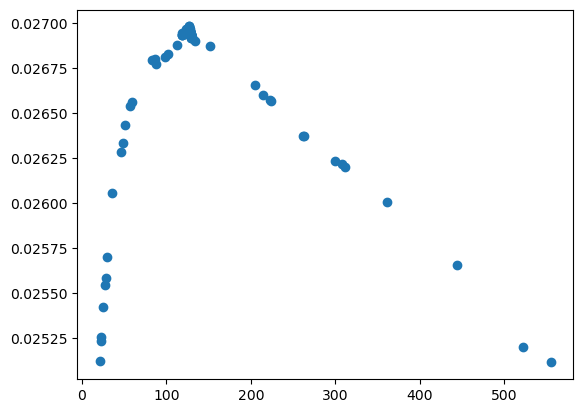

In [22]:
plt.scatter(df[df["result"] >= 0.025]["l2_norm"],df[df["result"] >= 0.025]["result"])
plt.show()